In [1]:
import pandas as pd
import numpy as np
from haversine import haversine
from pulp import *
import matplotlib.pyplot as plt
import time
from statistics import *
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import math
import json

In [2]:
start = time.time()

# Representative days and their frequencies:
rDays_idx = [149, 336, 1255, 1381, 1414, 1486, 2239, 3284, 3462]
rDaysFreq = {149: 79.705492, 336: 160.5743, 1255: 607.36725, 1381: 298.45277, 1414: 584.09253, 1486: 411.0, 2239: 557.55545, 3284: 32.5, 3462: 918.75222}

### Waste heat from industry data:
industrialWasteHeatPerMunicipality = {"Aa en Hunze": 3.65, "Bergen op Zoom": 2.6, "Borsele": 23.25, "Brummen": 9.75, "Delfzijl": 23.4, "Dordrecht": 4.9, "Gouda": 5.1, "Groningen": 4.4, "Hengelo": 17.3, "Maastricht": 11.25, "Midden-Groningen": 3.7, "Moerdijk": 107.05, "Roermond": 3.1, "Rotterdam": 281.6, "Sittard-Geleen": 157.8, "Steenbergen": 8, "Terneuzen": 128.7, "Velsen": 30.3, "Westerwolde": 3.75}
includedMunicipalitiesDueToWasteHeat = list(industrialWasteHeatPerMunicipality.keys())

### Loading time series data:
# Electricity demand
electricity_load_daily_db = pd.read_json("model_data/electricity_demand.json", orient="split")
electricity_load_daily_db = electricity_load_daily_db[["dayIndex", "Value"]]
electricity_load_daily = electricity_load_daily_db.as_matrix()

# Heat demand and DH share of municipalities
heat_demand_daily_db = pd.read_json("model_data/heat_demand.json", orient="split")

wasteHeatfromIndustry = pd.DataFrame(columns=list(heat_demand_daily_db.columns)[1:])

# Multiplied by 3 because of 3-hourly temporal resolution.
# Multiplied by 1000 to convert from MWh to KWh
for i in list(heat_demand_daily_db.columns)[1:]:
    if i in includedMunicipalitiesDueToWasteHeat:
        wasteHeatfromIndustry.loc[0, i] = industrialWasteHeatPerMunicipality[i] * 3 * 1000
    else:
        wasteHeatfromIndustry.loc[0, i] = 0

# household_data = pd.read_csv("model_dhData_13_08_2019.csv")
household_data = pd.read_csv("model_data/dh_scenario_ref.csv")
household_data.iloc[260, 0] = "'s-Hertogenbosch"
dh_share_data = [[], [], []]

includedMunicipalities = household_data.loc[household_data["decade_2_District_heating"] != 0]
includedMunicipalities = includedMunicipalities.reset_index(drop=True)
includedMunicipalities = list(includedMunicipalities["Municipalities"])

for i in includedMunicipalitiesDueToWasteHeat:
    if i not in includedMunicipalities:
        includedMunicipalities.append(i)

includedMunicipalities.append("dayIndex")

heat_demand_daily_db = heat_demand_daily_db.loc[:, heat_demand_daily_db.columns.isin(includedMunicipalities)]
heat_demand_daily = heat_demand_daily_db.as_matrix()

wasteHeatfromIndustry = wasteHeatfromIndustry.loc[:, wasteHeatfromIndustry.columns.isin(includedMunicipalities)]
wasteHeatfromIndustryMatrix = wasteHeatfromIndustry.as_matrix()

for i in list(heat_demand_daily_db)[1:]:
    dh_share_data[0].append(round(household_data.loc[household_data["Municipalities"] == i].values[0][1], 3))
    dh_share_data[1].append(round(household_data.loc[household_data["Municipalities"] == i].values[0][2], 3))
    dh_share_data[2].append(round(household_data.loc[household_data["Municipalities"] == i].values[0][3], 3))

# Solar output
solar_output_daily_db = pd.read_json("model_data/solar_output.json", orient="split")
solar_output_daily_db = solar_output_daily_db[["dayIndex", "Value"]]
solar_output_daily = solar_output_daily_db.as_matrix()

# Onshore output
onshore_output_db = pd.read_json("model_data/onshore_output.json", orient="split")
onshore_output_db = onshore_output_db[["dayIndex", "Value"]]
onshore_output_daily = onshore_output_db.as_matrix()

# Offshore output
offshore_output_db = pd.read_json("model_data/offshore_output.json", orient="split")
offshore_output_db = offshore_output_db[["dayIndex", "Value"]]
offshore_output_daily = offshore_output_db.as_matrix()

### Identifying the distance matrix:
lat_lon_data = pd.read_csv("model_data/lat_lon_values.csv")
lat_lon_data = lat_lon_data.drop(["population jan 1 2017", "population dec 31 2017"], axis=1)
lat_lon_data = lat_lon_data.sort_values(by=['gemeentenaam'], ascending=False)
lat_lon_data = lat_lon_data.reset_index(drop=True)

lat_lon_data = lat_lon_data.loc[lat_lon_data["gemeentenaam"].isin(includedMunicipalities)]
lat_lon_data = lat_lon_data.reset_index(drop=True)

distanceMatrix = np.zeros([len(lat_lon_data), len(lat_lon_data)])
for i in range(len(lat_lon_data)):
    lat1Value = lat_lon_data.iloc[i, 0]
    lon1Value = lat_lon_data.iloc[i, 1]
    coord1 = (lat1Value, lon1Value)

    for j in range(len(lat_lon_data)):
        lat2Value = lat_lon_data.iloc[j, 0]
        lon2Value = lat_lon_data.iloc[j, 1]
        coord2 = (lat2Value, lon2Value)
        distanceMatrix[i][j] = haversine(coord1, coord2)  # haversine distance between nodes, in kilometers.

### Loading the data which provides with "common municipal border" information.
includedMunicipalities = includedMunicipalities[:-1]
neighbours = pd.read_csv("model_data/neighboursDF.csv")
neighbours = neighbours.drop(["Unnamed: 0", "list_of_points"], axis=1)
for i in range(len(neighbours)):
    neighbours.loc[i, "neighbours"] = neighbours.iloc[i, 1][1:-1].split(", ")
    if neighbours.loc[i, "neighbours"] != ['']:
        neighbours.loc[i, "neighbours"] = list(map(int, neighbours.loc[i, "neighbours"]))
    else:
        neighbours.loc[i, "neighbours"] = []

neighbours_onlyIncludedMunis = neighbours.copy()

for i in range(len(neighbours_onlyIncludedMunis)):
    muniName = neighbours_onlyIncludedMunis.loc[i, "gemeentenaam"]
    if muniName not in includedMunicipalities:
        neighbourNumber = len(neighbours_onlyIncludedMunis.loc[i, "neighbours"])
        for j in range(neighbourNumber):
            neighbourIndex = neighbours_onlyIncludedMunis.loc[i, "neighbours"][j]
            neighbours_onlyIncludedMunis.loc[neighbourIndex, "neighbours"].remove(i)

neighbours_onlyIncludedMunis = neighbours.loc[neighbours["gemeentenaam"].isin(includedMunicipalities), :]
neighbours_onlyIncludedMunis = neighbours_onlyIncludedMunis.reset_index(drop=True)

for i in tqdm(range(len(neighbours_onlyIncludedMunis))):
    numberMunis = len(neighbours_onlyIncludedMunis.loc[i, "neighbours"])

    for j in range(numberMunis):
        neighbourOriginalIndex = neighbours_onlyIncludedMunis.loc[i, "neighbours"][j]
        neighbourOriginalName = neighbours.loc[neighbourOriginalIndex, "gemeentenaam"]

        neighbourNewIndex = neighbours_onlyIncludedMunis.loc[neighbours_onlyIncludedMunis["gemeentenaam"] == neighbourOriginalName].index
        neighbours_onlyIncludedMunis.loc[i, "neighbours"][j] = neighbourNewIndex[0]


C:\Users\codingPurposes\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
C:\Users\codingPurposes\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\codingPurposes\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\codingPurposes\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\codingPurposes\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\codingPurposes\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: FutureWarning: Method .as_matrix wil

In [3]:
### Getting started with the actual model calculations:
technologies_data = pd.read_csv("model_data/technologies_db.csv")

# Converting €/MW to €/kW:
for i in range(4):
    row_inv = 4 + i * 7
    technologies_data.iloc[row_inv, 2:] = technologies_data.iloc[row_inv, 2:] / 1000

    row_om = 5 + i * 7
    technologies_data.iloc[row_om, 2:] = technologies_data.iloc[row_om, 2:] / 1000

    row_var_om = 6 + i * 7
    technologies_data.iloc[row_var_om, 2:] = technologies_data.iloc[row_var_om, 2:] / 1000

for i in range(len(technologies_data)):
    for j in range(2, len(list(technologies_data))):
        technologies_data.iloc[i, j] = round(technologies_data.iloc[i, j], 3)

facility_om_cost = []
facility_inv_cost = []
variable_om_cost = []
facility_elec_eff = []
facility_thermal_eff = []

for i in range(3):
    row = 4 + i * 7
    facility_inv_cost.append(list(technologies_data.iloc[row, 2:-1]))

for i in range(3):
    row = 5 + i * 7
    facility_om_cost.append(list(technologies_data.iloc[row, 2:-1]))

for i in range(3):
    row = 6 + i * 7
    variable_om_cost.append(list(technologies_data.iloc[row, 2:-1]))

for f in range(2, 11):
    empty_list = []
    for i in range(4):
        row = 0 + i * 7
        empty_list.append(technologies_data.iloc[row, f])

    facility_elec_eff.append(mean(empty_list))

for f in range(2, 11):
    empty_list = []
    for i in range(4):
        row = 1 + i * 7
        empty_list.append(technologies_data.iloc[row, f])

    facility_thermal_eff.append(mean(empty_list))

# Fuel parameters:
coal_cv = 7.972  # coal's calorific value, unit=kWh/kg
gas_cv = 8.792  # natural gas' calorific value, unit=kWh/m3
biomass_cv = 4.194  # biomass' calorific value, unit=kWh/kg
coal_co2 = 2.698  # coal's co2 emission value, unit=kg of CO2/kg of coal
gas_co2 = 1.776  # natural gas' co2 emission value, unit=kg of CO2/m3 of gas
biomass_co2 = 0  # biomass' co2 emission value, unit=kg of CO2/kg of biomass
coal_cost = 0.0893  # coal's unit cost, unit=€/kg
gas_cost = 0.196  # natural gas' unit cost, unit=€/m3
biomass_cost = 0.113238  # biomass' unit cost, unit=€/kg

facility_fuel_cv = [coal_cv, gas_cv, biomass_cv, coal_cv, gas_cv, biomass_cv, biomass_cv, gas_cv]
facility_fuel_cost = [coal_cost, gas_cost, biomass_cost, coal_cost, gas_cost, biomass_cost, biomass_cost, gas_cost]
facility_fuel_co2 = [coal_co2, gas_co2, biomass_co2, coal_co2, gas_co2, biomass_co2, biomass_co2, gas_co2]

# https://www.mkba-informatie.nl/mkba-voor-gevorderden/richtlijnen/rapport-werkgroep-discontovoet-2015/
interestRate = 0.045  # yearly interest rate for such projects ()
interest_coef = []
for i in range(30, 0, -1):
    interest_coef.append(round((1 + interestRate) ** i, 3))

# "the impact of heat losses in the main lines (primary network) accounts for approximately 2% to 5% of the
# total distributed heat if the insulation is in good condition" Optimizing the District Heating Primary Network from
# the Perspective of Economic-Specific Pressure Loss Haichao Wang 1,2, Lin Duanmu 1, Xiangli Li 1,* and Risto
# Lahdelma 2 ---> heat loss = 3.5%
heat_loss_effect = 0.965

# Pipeline investment cost:
unit_pipeline_cost_perMW = 53.44  # € per m per MW
unit_pipeline_cost_perkW = unit_pipeline_cost_perMW / 1000

In [4]:
municipalities = list(range(len(includedMunicipalities)))
chp_facilities = [0, 1, 2]
only_electricity_facilities = [3, 4, 5]
only_heat_facilities = [6, 7]
decades = list(range(3))
rDays = list(range(9))
hours = list(range(8))

initial_cap_chp = np.zeros([len(municipalities), len(chp_facilities)])
initial_cap_heat = np.zeros([len(municipalities), len(only_heat_facilities)])
initial_cap_hp = np.zeros([len(municipalities)])
initial_cap_elec = np.zeros([len(only_electricity_facilities)])
initial_cap_solar = 0
initial_cap_onshore = 0
initial_cap_offshore = 0

# Additional capacity installation variables
add_cap_chp = LpVariable.dicts("add_cap_chp", (decades, municipalities, chp_facilities), lowBound=0, cat=LpContinuous)
current_cap_chp = LpVariable.dicts("current_cap_chp", (decades, municipalities, chp_facilities), lowBound=0, cat=LpContinuous)

add_cap_elec = LpVariable.dicts("add_cap_elec", (decades, only_electricity_facilities), lowBound=0, cat=LpContinuous)
current_cap_elec = LpVariable.dicts("current_cap_elec", (decades, only_electricity_facilities), lowBound=0, cat=LpContinuous)

add_cap_heat = LpVariable.dicts("add_cap_heat", (decades, municipalities, only_heat_facilities), lowBound=0, cat=LpContinuous)
current_cap_heat = LpVariable.dicts("current_cap_heat", (decades, municipalities, only_heat_facilities), lowBound=0, cat=LpContinuous)

add_cap_hp = LpVariable.dicts("add_cap_hp", (decades, municipalities), lowBound=0, cat=LpContinuous)
current_cap_hp = LpVariable.dicts("current_cap_hp", (decades, municipalities), lowBound=0, cat=LpContinuous)

add_cap_solar = LpVariable.dicts("add_cap_solar", decades, lowBound=0, cat=LpContinuous)
current_cap_solar = LpVariable.dicts("current_cap_solar", decades, lowBound=0, cat=LpContinuous)

add_cap_onshore = LpVariable.dicts("add_cap_onshore", decades, lowBound=0, cat=LpContinuous)
current_cap_onshore = LpVariable.dicts("current_cap_onshore", decades, lowBound=0, cat=LpContinuous)

add_cap_offshore = LpVariable.dicts("add_cap_offshore", decades, lowBound=0, cat=LpContinuous)
current_cap_offshore = LpVariable.dicts("current_cap_offshore", decades, lowBound=0, cat=LpContinuous)

add_pipe_cap = np.empty([len(municipalities)], dtype=object)
current_pipe_cap = np.empty([len(municipalities)], dtype=object)
for m in municipalities:
    if neighbours_onlyIncludedMunis.iloc[m, 1] != []:
        add_pipe_cap[m] = LpVariable.dicts("add_pipe_cap" + str(m), (neighbours_onlyIncludedMunis.iloc[m, 1], decades), lowBound=0, cat=LpContinuous)
        current_pipe_cap[m] = LpVariable.dicts("current_pipe_cap" + str(m), (neighbours_onlyIncludedMunis.iloc[m, 1], decades), lowBound=0, cat=LpContinuous)

# Operational decisions:
amount_fuel_chp = LpVariable.dicts("amount_fuel_chp", (decades, rDays, hours, municipalities, chp_facilities), lowBound=0, cat=LpContinuous)
amount_fuel_elec = LpVariable.dicts("amount_fuel_elec", (decades, rDays, hours, only_electricity_facilities), lowBound=0, cat=LpContinuous)
amount_fuel_heat = LpVariable.dicts("amount_fuel_heat", (decades, rDays, hours, municipalities, only_heat_facilities), lowBound=0, cat=LpContinuous)
amount_electricity_hp = LpVariable.dicts("amount_electricity_hp", (decades, rDays, hours, municipalities), lowBound=0, cat=LpContinuous)

generated_electricity = LpVariable.dicts("generated_electricity", (decades, rDays, hours), lowBound=0, cat=LpContinuous)
spilled_electricity = LpVariable.dicts("spilled_electricity", (decades, rDays, hours), lowBound=0, cat=LpContinuous)
generated_heat = LpVariable.dicts("generated_heat", (decades, rDays, hours, municipalities), lowBound=0, cat=LpContinuous)
spilled_heat = LpVariable.dicts("spilled_heat", (decades, rDays, hours, municipalities), lowBound=0, cat=LpContinuous)

transferred_heat = np.empty([len(municipalities)], dtype=object)
for m in municipalities:
    transferred_heat[m] = LpVariable.dicts("transferred_heat" + str(m), (decades, rDays, hours, neighbours_onlyIncludedMunis.iloc[m, 1]), lowBound=0, cat=LpContinuous)

# Investment decisions:
CHP_investment_cost = LpVariable("CHP_investment_cost", 0, None, LpContinuous)
ELEC_investment_cost = LpVariable("ELEC_investment_cost", 0, None, LpContinuous)
HEAT_investment_cost = LpVariable("HEAT_investment_cost", 0, None, LpContinuous)
HP_investment_cost = LpVariable("HP_investment_cost", 0, None, LpContinuous)
SOLAR_investment_cost = LpVariable("SOLAR_investment_cost", 0, None, LpContinuous)
ONSHORE_investment_cost = LpVariable("ONSHORE_investment_cost", 0, None, LpContinuous)
OFFSHORE_investment_cost = LpVariable("OFFSHORE_investment_cost", 0, None, LpContinuous)
PIPE_investment_cost = LpVariable("PIPE_investment_cost", 0, None, LpContinuous)

# Annual O&M decisions:
CHP_om_cost = LpVariable("CHP_om_cost", 0, None, LpContinuous)
ELEC_om_cost = LpVariable("ELEC_om_cost", 0, None, LpContinuous)
HEAT_om_cost = LpVariable("HEAT_om_cost", 0, None, LpContinuous)
HP_om_cost = LpVariable("HP_om_cost", 0, None, LpContinuous)
SOLAR_om_cost = LpVariable("SOLAR_om_cost", 0, None, LpContinuous)
ONSHORE_om_cost = LpVariable("ONSHORE_om_cost", 0, None, LpContinuous)
OFFSHORE_om_cost = LpVariable("OFFSHORE_om_cost", 0, None, LpContinuous)

# Variable O&M decisions:
CHP_var_cost = LpVariable.dicts("CHP_var_cost", (decades, rDays), lowBound=0, cat=LpContinuous)
ELEC_var_cost = LpVariable.dicts("ELEC_var_cost", (decades, rDays), lowBound=0, cat=LpContinuous)
HEAT_var_cost = LpVariable.dicts("HEAT_var_cost", (decades, rDays), lowBound=0, cat=LpContinuous)
HP_var_cost = LpVariable.dicts("HP_var_cost", (decades, rDays), lowBound=0, cat=LpContinuous)
SOLAR_var_cost = LpVariable.dicts("SOLAR_var_cost", (decades, rDays), lowBound=0, cat=LpContinuous)
ONSHORE_var_cost = LpVariable.dicts("ONSHORE_var_cost", (decades, rDays), lowBound=0, cat=LpContinuous)
OFFSHORE_var_cost = LpVariable.dicts("OFFSHORE_var_cost", (decades, rDays), lowBound=0, cat=LpContinuous)
decade_var_cost = LpVariable.dicts("decade_var_cost", decades, lowBound=0, cat=LpContinuous)

# Fuel cost decisions:
daily_fuel_cost = LpVariable.dicts("daily_fuel_cost", (decades, rDays), lowBound=0, cat=LpContinuous)
decade_fuel_cost = LpVariable.dicts("decade_fuel_cost", decades, lowBound=0, cat=LpContinuous)
CHP_fuel_cost = LpVariable.dicts("CHP_fuel_cost", (decades, rDays), lowBound=0, cat=LpContinuous)
HEAT_fuel_cost = LpVariable.dicts("HEAT_fuel_cost", (decades, rDays), lowBound=0, cat=LpContinuous)
ELEC_fuel_cost = LpVariable.dicts("ELEC_fuel_cost", (decades, rDays), lowBound=0, cat=LpContinuous)

# Emissions:
daily_emissions = LpVariable.dicts("daily_emissions", (decades, rDays), lowBound=0, cat=LpContinuous)
decade_emissions = LpVariable.dicts("decade_emissions", decades, lowBound=0, cat=LpContinuous)
CHP_emissions = LpVariable.dicts("CHP_emissions", (decades, rDays), lowBound=0, cat=LpContinuous)
HEAT_emissions = LpVariable.dicts("HEAT_emissions", (decades, rDays), lowBound=0, cat=LpContinuous)
ELEC_emissions = LpVariable.dicts("ELEC_emissions", (decades, rDays), lowBound=0, cat=LpContinuous)

# Total values:
total_om_cost = LpVariable("total_om_cost", 0, None, LpContinuous)
total_var_cost = LpVariable("total_var_cost", 0, None, LpContinuous)
total_fuel_cost = LpVariable("total_fuel_cost", 0, None, LpContinuous)
total_investment_cost = LpVariable("total_investment_cost", 0, None, LpContinuous)
total_emissions = LpVariable("total_emissions", 0, None, LpContinuous)
total_cost = LpVariable("total_cost", 0, None, LpContinuous)


In [5]:
model = LpProblem("LpModel", LpMinimize)
model += total_cost

In [6]:
# CHP facilities:
for m in municipalities:
    for f in chp_facilities:
        model += current_cap_chp[0][m][f] == initial_cap_chp[m][f] + add_cap_chp[0][m][f]
        model += current_cap_chp[1][m][f] == current_cap_chp[0][m][f] + add_cap_chp[1][m][f]
        model += current_cap_chp[2][m][f] == current_cap_chp[1][m][f] + add_cap_chp[2][m][f]

# Electricity generation facilities:
for f in only_electricity_facilities:
    model += current_cap_elec[0][f] == initial_cap_elec[f - 3] + add_cap_elec[0][f]
    model += current_cap_elec[1][f] == current_cap_elec[0][f] + add_cap_elec[1][f]
    model += current_cap_elec[2][f] == current_cap_elec[1][f] + add_cap_elec[2][f]

# Heat generation facilities:
for m in municipalities:
    for f in only_heat_facilities:
        model += current_cap_heat[0][m][f] == initial_cap_heat[m][f - 6] + add_cap_heat[0][m][f]
        model += current_cap_heat[1][m][f] == current_cap_heat[0][m][f] + add_cap_heat[1][m][f]
        model += current_cap_heat[2][m][f] == current_cap_heat[1][m][f] + add_cap_heat[2][m][f]

# Heat pumps:
for m in municipalities:
    model += current_cap_hp[0][m] == initial_cap_hp[m] + add_cap_hp[0][m]
    model += current_cap_hp[1][m] == current_cap_hp[0][m] + add_cap_hp[1][m]
    model += current_cap_hp[2][m] == current_cap_hp[1][m] + add_cap_hp[2][m]

# Solar panels:
model += current_cap_solar[0] == initial_cap_solar + add_cap_solar[0]
model += current_cap_solar[1] == current_cap_solar[0] + add_cap_solar[1]
model += current_cap_solar[2] == current_cap_solar[1] + add_cap_solar[2]

# Onshore wind farms:
model += current_cap_onshore[0] == initial_cap_onshore + add_cap_onshore[0]
model += current_cap_onshore[1] == current_cap_onshore[0] + add_cap_onshore[1]
model += current_cap_onshore[2] == current_cap_onshore[1] + add_cap_onshore[2]

# Offshore wind farms:
model += current_cap_offshore[0] == initial_cap_offshore + add_cap_offshore[0]
model += current_cap_offshore[1] == current_cap_offshore[0] + add_cap_offshore[1]
model += current_cap_offshore[2] == current_cap_offshore[1] + add_cap_offshore[2]

# Initializing the pipeline network:
for m in municipalities:
    supplierMunicipalities = neighbours_onlyIncludedMunis.iloc[m, 1]
    for s in supplierMunicipalities:
        model += current_pipe_cap[m][s][0] == add_pipe_cap[m][s][0]
        model += current_pipe_cap[m][s][1] == current_pipe_cap[m][s][0] + add_pipe_cap[m][s][1]
        model += current_pipe_cap[m][s][2] == current_pipe_cap[m][s][1] + add_pipe_cap[m][s][2]

for y in decades:
    for m in municipalities:
        supplierMunicipalities = neighbours_onlyIncludedMunis.iloc[m, 1]
        for s in supplierMunicipalities:
            model += current_pipe_cap[m][s][y] == current_pipe_cap[s][m][y]

        ### Generated electricity:
for y in tqdm(decades):
    for d in rDays:
        for h in hours:
            model += generated_electricity[y][d][h] == (sum(amount_fuel_chp[y][d][h][m][f] * facility_fuel_cv[f] * facility_elec_eff[f]
                                                            for m in municipalities
                                                            for f in chp_facilities)
                                                        +
                                                        sum(amount_fuel_elec[y][d][h][f] * facility_fuel_cv[f] * facility_elec_eff[f]
                                                            for f in only_electricity_facilities)
                                                        +
                                                        current_cap_solar[y] * solar_output_daily[y * 9 + d][1][h]
                                                        +
                                                        current_cap_onshore[y] * onshore_output_daily[y * 9 + d][1][h]
                                                        +
                                                        current_cap_offshore[y] * offshore_output_daily[y * 9 + d][1][h]
                                                        )

### Electricity demand should be fulfilled:
for y in tqdm(decades):
    for d in rDays:
        for h in hours:
            model += generated_electricity[y][d][h] == electricity_load_daily[y * 9 + d][1][h] + sum(amount_electricity_hp[y][d][h][m] for m in municipalities) + spilled_electricity[y][d][h]

### Generated heat:
for y in tqdm(decades):
    for d in rDays:
        for h in hours:
            for m in municipalities:
                model += generated_heat[y][d][h][m] == (sum(amount_fuel_chp[y][d][h][m][f] * facility_fuel_cv[f] * facility_thermal_eff[f]
                                                            for f in chp_facilities)
                                                        +
                                                        sum(amount_fuel_heat[y][d][h][m][f] * facility_fuel_cv[f] * facility_thermal_eff[f]
                                                            for f in only_heat_facilities)
                                                        +
                                                        amount_electricity_hp[y][d][h][m] * facility_thermal_eff[8]
                                                        +
                                                        wasteHeatfromIndustryMatrix[0][m]
                                                        )

### Heat demand should be fulfilled:
for y in tqdm(decades):
    for d in rDays:
        for h in hours:
            for m in municipalities:
                supplierMunicipalities = neighbours_onlyIncludedMunis.iloc[m, 1]
                model += generated_heat[y][d][h][m] + sum(transferred_heat[s][y][d][h][m] * heat_loss_effect for s in supplierMunicipalities) == heat_demand_daily[y * 9 + d][m + 1][h] * dh_share_data[y][m] + sum(transferred_heat[m][y][d][h][s] for s in supplierMunicipalities) + spilled_heat[y][d][h][m]

### Amount of generated electricity, heat <= capacity of facility
# CHP facilities:
for y in tqdm(decades):
    for d in rDays:
        for h in hours:
            for m in municipalities:
                for f in chp_facilities:
                    model += amount_fuel_chp[y][d][h][m][f] * facility_fuel_cv[f] * facility_elec_eff[f] <= current_cap_chp[y][m][f] * 3

    # Electricity generation facilities:
    for d in rDays:
        for h in hours:
            for f in only_electricity_facilities:
                model += amount_fuel_elec[y][d][h][f] * facility_fuel_cv[f] * facility_elec_eff[f] <= current_cap_elec[y][f] * 3

    # Heat generation facilities:
    for d in rDays:
        for h in hours:
            for m in municipalities:
                for f in only_heat_facilities:
                    model += amount_fuel_heat[y][d][h][m][f] * facility_fuel_cv[f] * facility_thermal_eff[f] <= current_cap_heat[y][m][f] * 3

    # Heat pumps:
    for d in rDays:
        for h in hours:
            for m in municipalities:
                model += amount_electricity_hp[y][d][h][m] * facility_thermal_eff[8] <= current_cap_hp[y][m] * 3

# There is no need to declare capacity constraints for solar and wind facilities since they do not have a decision variable
# with respect to their operational issues. Instead, they are assumed to be used whenever they are available since
# they are coming 1st in the merit order (no fuel cost).


for y in tqdm(decades):
    for d in rDays:
        for h in hours:
            for m in municipalities:
                supplierMunicipalities = neighbours_onlyIncludedMunis.iloc[m, 1]
                for s in supplierMunicipalities:
                    model += transferred_heat[s][y][d][h][m] <= current_pipe_cap[s][m][y] * 3

### Investment costs:
model += CHP_investment_cost == sum(add_cap_chp[y][m][f] * facility_inv_cost[y][f] * interest_coef[y * 10]
                                    for y in decades
                                    for m in municipalities
                                    for f in chp_facilities
                                    )

model += ELEC_investment_cost == sum(add_cap_elec[y][f] * facility_inv_cost[y][f] * interest_coef[y * 10]
                                     for y in decades
                                     for f in only_electricity_facilities)

model += HEAT_investment_cost == sum(add_cap_heat[y][m][f] * facility_inv_cost[y][f] * interest_coef[y * 10]
                                     for y in decades
                                     for m in municipalities
                                     for f in only_heat_facilities)

model += HP_investment_cost == sum(add_cap_hp[y][m] * facility_inv_cost[y][8] * interest_coef[y * 10]
                                   for y in decades
                                   for m in municipalities)

model += SOLAR_investment_cost == sum(add_cap_solar[y] * facility_inv_cost[y][9] * interest_coef[y * 10]
                                      for y in decades
                                      )

model += ONSHORE_investment_cost == sum(add_cap_onshore[y] * facility_inv_cost[y][10] * interest_coef[y * 10]
                                        for y in decades
                                        )

model += OFFSHORE_investment_cost == sum(add_cap_offshore[y] * facility_inv_cost[y][11] * interest_coef[y * 10]
                                         for y in decades
                                         )

# distanceMatrix was in km, by multiplying it with 1000, it is converted to m.
# multiplication with 0.5 --> pipeline from x to y, is the same pipeline which is from y to x.
model += PIPE_investment_cost == sum(add_pipe_cap[m][s][y] * unit_pipeline_cost_perkW * interest_coef[y * 10] * distanceMatrix[m][s] * 1000
                                     for y in decades
                                     for m in municipalities
                                     for s in neighbours_onlyIncludedMunis.iloc[m, 1]
                                     ) * 0.5

model += total_investment_cost == CHP_investment_cost + ELEC_investment_cost + HEAT_investment_cost + HP_investment_cost + SOLAR_investment_cost + ONSHORE_investment_cost + OFFSHORE_investment_cost + PIPE_investment_cost

### Annual o&m costs:
model += CHP_om_cost == sum(current_cap_chp[y][m][f] * facility_om_cost[y][f] * (sum(interest_coef[y * 10:y * 10 + 10]))
                            for y in decades
                            for m in municipalities
                            for f in chp_facilities)

model += ELEC_om_cost == sum(current_cap_elec[y][f] * facility_om_cost[y][f] * (sum(interest_coef[y * 10:y * 10 + 10]))
                             for y in decades
                             for f in only_electricity_facilities)

model += HEAT_om_cost == sum(current_cap_heat[y][m][f] * facility_om_cost[y][f] * (sum(interest_coef[y * 10:y * 10 + 10]))
                             for y in decades
                             for m in municipalities
                             for f in only_heat_facilities)

model += HP_om_cost == sum(current_cap_hp[y][m] * facility_om_cost[y][8] * (sum(interest_coef[y * 10:y * 10 + 10]))
                           for y in decades
                           for m in municipalities)

model += SOLAR_om_cost == sum(current_cap_solar[y] * facility_om_cost[y][9] * (sum(interest_coef[y * 10:y * 10 + 10]))
                              for y in decades)

model += ONSHORE_om_cost == sum(current_cap_onshore[y] * facility_om_cost[y][10] * (sum(interest_coef[y * 10:y * 10 + 10]))
                                for y in decades)

model += OFFSHORE_om_cost == sum(current_cap_offshore[y] * facility_om_cost[y][11] * (sum(interest_coef[y * 10:y * 10 + 10]))
                                 for y in decades)

model += total_om_cost == CHP_om_cost + ELEC_om_cost + HEAT_om_cost + HP_om_cost + SOLAR_om_cost + ONSHORE_om_cost + OFFSHORE_om_cost

### Variable o&m costs:
for y in tqdm(decades):
    for d in rDays:
        model += CHP_var_cost[y][d] == (sum(amount_fuel_chp[y][d][h][m][f] * facility_fuel_cv[f] * facility_elec_eff[f] * variable_om_cost[y][f]
                                            for h in hours
                                            for m in municipalities
                                            for f in chp_facilities))

        model += ELEC_var_cost[y][d] == (sum(amount_fuel_elec[y][d][h][f] * facility_fuel_cv[f] * facility_elec_eff[f] * variable_om_cost[y][f]
                                             for h in hours
                                             for f in only_electricity_facilities))

        model += HEAT_var_cost[y][d] == (sum(amount_fuel_heat[y][d][h][m][f] * facility_fuel_cv[f] * facility_thermal_eff[f] * variable_om_cost[y][f]
                                             for h in hours
                                             for m in municipalities
                                             for f in only_heat_facilities))

        model += HP_var_cost[y][d] == (sum(amount_electricity_hp[y][d][h][m] * facility_thermal_eff[8] * variable_om_cost[y][8]
                                           for h in hours
                                           for m in municipalities))

        model += SOLAR_var_cost[y][d] == (sum(current_cap_solar[y] * solar_output_daily[y * 9 + d][1][h] * variable_om_cost[y][9]
                                              for h in hours))

        model += ONSHORE_var_cost[y][d] == (sum(current_cap_onshore[y] * onshore_output_daily[y * 9 + d][1][h] * variable_om_cost[y][10]
                                                for h in hours))

        model += OFFSHORE_var_cost[y][d] == (sum(current_cap_offshore[y] * offshore_output_daily[y * 9 + d][1][h] * variable_om_cost[y][11]
                                                 for h in hours))

for y in tqdm(decades):
    model += decade_var_cost[y] == sum((CHP_var_cost[y][d] +
                                        ELEC_var_cost[y][d] +
                                        HEAT_var_cost[y][d] +
                                        HP_var_cost[y][d] +
                                        SOLAR_var_cost[y][d] +
                                        ONSHORE_var_cost[y][d] +
                                        OFFSHORE_var_cost[y][d]) * (rDaysFreq[rDays_idx[d]]) for d in rDays)

model += total_var_cost == sum(decade_var_cost[y] * (interest_coef[(10 * y) + 5])
                               for y in decades)

### Fuel costs with the effect of compound interest over the years
for y in tqdm(decades):
    for d in rDays:
        model += daily_fuel_cost[y][d] == (sum(amount_fuel_chp[y][d][h][m][f] * facility_fuel_cost[f]
                                               for h in hours
                                               for m in municipalities
                                               for f in chp_facilities)
                                           +
                                           sum(amount_fuel_heat[y][d][h][m][f] * facility_fuel_cost[f]
                                               for h in hours
                                               for m in municipalities
                                               for f in only_heat_facilities)
                                           +
                                           sum(amount_fuel_elec[y][d][h][f] * facility_fuel_cost[f]
                                               for h in hours
                                               for f in only_electricity_facilities)
                                           )

for y in tqdm(decades):
    model += decade_fuel_cost[y] == (sum(daily_fuel_cost[y][d] * (rDaysFreq[rDays_idx[d]]) for d in rDays))

model += total_fuel_cost == sum(decade_fuel_cost[y] * (interest_coef[(10 * y) + 5])
                                for y in decades)

### Emissions:
for y in tqdm(decades):
    for d in rDays:
        model += daily_emissions[y][d] == (sum(amount_fuel_chp[y][d][h][m][f] * facility_fuel_co2[f]
                                               for h in hours
                                               for m in municipalities
                                               for f in chp_facilities)
                                           +
                                           sum(amount_fuel_heat[y][d][h][m][f] * facility_fuel_co2[f]
                                               for h in hours
                                               for m in municipalities
                                               for f in only_heat_facilities)
                                           +
                                           sum(amount_fuel_elec[y][d][h][f] * facility_fuel_co2[f]
                                               for h in hours
                                               for f in only_electricity_facilities)
                                           )

for y in tqdm(decades):
    model += decade_emissions[y] == (sum(daily_emissions[y][d] * (rDaysFreq[rDays_idx[d]]) for d in rDays))

model += total_emissions == sum(decade_emissions[y] for y in decades)

### No coal power plant, no coal chp
for y in decades:
    for m in municipalities:
        model += current_cap_chp[y][m][0] == 0
        model += current_cap_elec[y][3] == 0

model += decade_emissions[1] <= decade_emissions[0] * 0.51
model += decade_emissions[2] <= decade_emissions[0] * 0.05
model += total_cost == total_investment_cost + total_fuel_cost + total_om_cost + total_var_cost

model.solve()
print("Status:", LpStatus[model.status])
print(value(total_cost))
print(value(total_emissions))

end = time.time()
print(end - start)

100%|██████████| 3/3 [00:00<00:00, 2997.36it/s]


Status: Optimal
540656660000.0
525904470000.0
2481.989928007126


In [ ]:
resultsDict = {}
for variable in tqdm(model.variables()):
    resultsDict[variable.name] = variable.varValue
    # print('{} = {}'.format(variable.name, variable.varValue))

with open("results.json", 'w') as fp:
    json.dump(resultsDict, fp)

### Electricity system - installed capacities

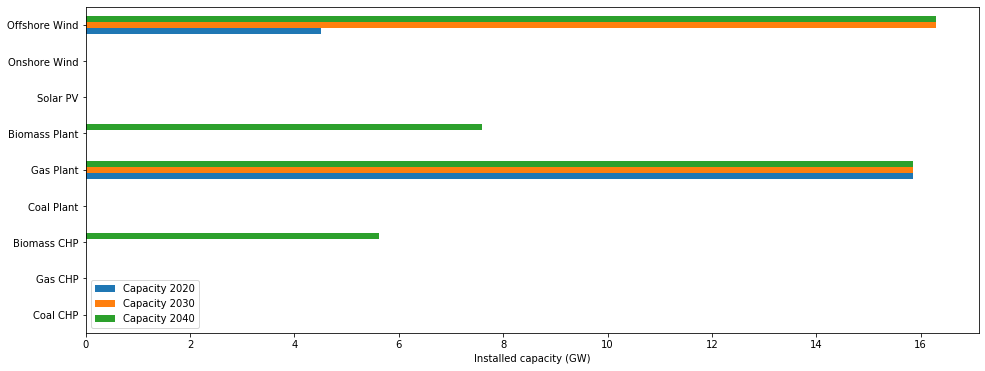

In [7]:
result_current_cap_chp_COAL = []
result_current_cap_chp_GAS = []
result_current_cap_chp_BIOMASS = []
result_current_cap_elec_COAL = []
result_current_cap_elec_GAS = []
result_current_cap_elec_BIOMASS = []
result_current_cap_solar = []
result_current_cap_onshore = []
result_current_cap_offshore = []

for y in decades:
    result_current_cap_chp_COAL.append(sum(value(current_cap_chp[y][m][0]) for m in municipalities))
    result_current_cap_chp_GAS.append(sum(value(current_cap_chp[y][m][1]) for m in municipalities))
    result_current_cap_chp_BIOMASS.append(sum(value(current_cap_chp[y][m][2]) for m in municipalities))
    result_current_cap_elec_COAL.append(value(current_cap_elec[y][3]))
    result_current_cap_elec_GAS.append(value(current_cap_elec[y][4]))
    result_current_cap_elec_BIOMASS.append(value(current_cap_elec[y][5]))
    result_current_cap_solar.append(value(current_cap_solar[y]))
    result_current_cap_onshore.append(value(current_cap_onshore[y]))
    result_current_cap_offshore.append(value(current_cap_offshore[y]))

result_current_cap_df = pd.DataFrame(columns=["Facilities", "Capacity(kW)"])
result_current_cap_df["Facilities"] = ["Coal CHP", "Gas CHP", "Biomass CHP", "Coal Plant", "Gas Plant", "Biomass Plant", "Solar PV", "Onshore Wind", "Offshore Wind"]
result_current_cap_df.loc[0, "Capacity(kW)"] =  result_current_cap_chp_COAL
result_current_cap_df.loc[1, "Capacity(kW)"] =  result_current_cap_chp_GAS
result_current_cap_df.loc[2, "Capacity(kW)"] =  result_current_cap_chp_BIOMASS
result_current_cap_df.loc[3, "Capacity(kW)"] =  result_current_cap_elec_COAL
result_current_cap_df.loc[4, "Capacity(kW)"] =  result_current_cap_elec_GAS
result_current_cap_df.loc[5, "Capacity(kW)"] =  result_current_cap_elec_BIOMASS
result_current_cap_df.loc[6, "Capacity(kW)"] =  result_current_cap_solar
result_current_cap_df.loc[7, "Capacity(kW)"] = result_current_cap_onshore 
result_current_cap_df.loc[8, "Capacity(kW)"] = result_current_cap_offshore 

result_current_cap_df_2020 = []
result_current_cap_df_2030 = []
result_current_cap_df_2040 = []

for i in range(9):
    result_current_cap_df_2020.append(result_current_cap_df.loc[i,"Capacity(kW)"][0]/1000000)
    result_current_cap_df_2030.append(result_current_cap_df.loc[i,"Capacity(kW)"][1]/1000000)
    result_current_cap_df_2040.append(result_current_cap_df.loc[i,"Capacity(kW)"][2]/1000000)
    
index = ['Coal CHP', 'Gas CHP', 'Biomass CHP', 'Coal Plant', 'Gas Plant', 'Biomass Plant', 'Solar PV', 'Onshore Wind', 'Offshore Wind']
df = pd.DataFrame({'Capacity 2020': result_current_cap_df_2020,
                   'Capacity 2030': result_current_cap_df_2030,
                   'Capacity 2040': result_current_cap_df_2040}, index=index)
ax = df.plot(kind="barh", figsize=[16,6])
ax.set_xlabel("Installed capacity (GW)")

fig = ax.get_figure()
fig.savefig('installedCap_electricity.png')

### Pipeline cap

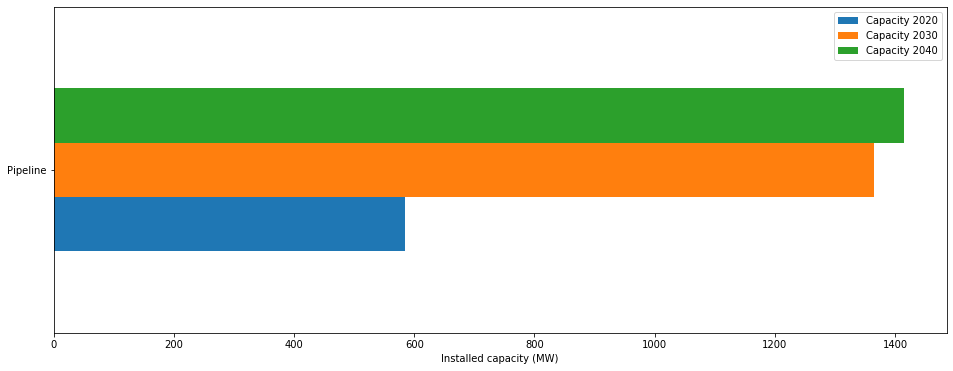

In [8]:
result_current_pipe_cap = []

for y in decades:
    result_current_pipe_cap.append(sum(value(current_pipe_cap[m][s][y]) for m in municipalities for s in neighbours_onlyIncludedMunis.iloc[m,1]))

result_current_cap_df = pd.DataFrame(columns=["Facilities", "Capacity(kW)"])
result_current_cap_df["Facilities"] = ["Pipeline"]
result_current_cap_df.loc[0, "Capacity(kW)"] = result_current_pipe_cap 

result_current_cap_df_2020 = []
result_current_cap_df_2030 = []
result_current_cap_df_2040 = []

# Conversion to MW
for i in range(1):
    result_current_cap_df_2020.append(result_current_cap_df.loc[i,"Capacity(kW)"][0]/1000)
    result_current_cap_df_2030.append(result_current_cap_df.loc[i,"Capacity(kW)"][1]/1000)
    result_current_cap_df_2040.append(result_current_cap_df.loc[i,"Capacity(kW)"][2]/1000)
    
index = ['Pipeline']
df = pd.DataFrame({'Capacity 2020': result_current_cap_df_2020,
                   'Capacity 2030': result_current_cap_df_2030,
                   'Capacity 2040': result_current_cap_df_2040}, index=index)
ax = df.plot(kind="barh", figsize=[16,6])
ax.set_xlabel("Installed capacity (MW)")

fig = ax.get_figure()
fig.savefig(r'installedCap_pipe.png')

### Heating system - installed capacities

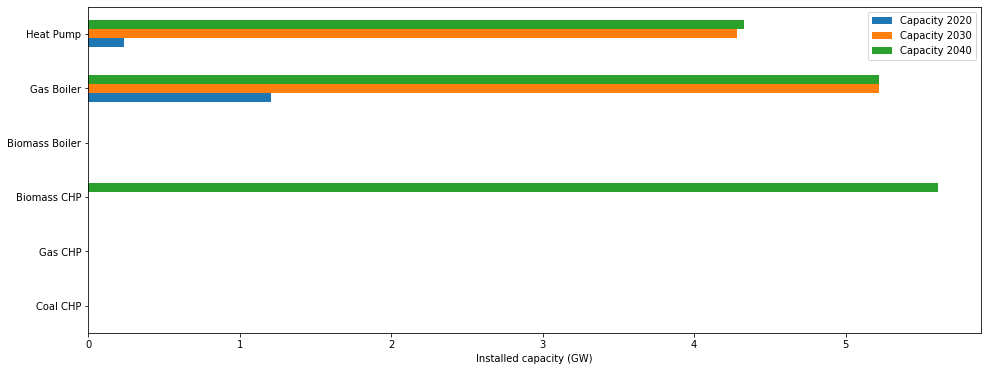

In [9]:
result_current_cap_chp_COAL = []
result_current_cap_chp_GAS = []
result_current_cap_chp_BIOMASS = []
result_current_cap_heat_BIOMASS = []
result_current_cap_heat_GAS = []
result_current_cap_hp = []

for y in decades:
    result_current_cap_chp_COAL.append(sum(value(current_cap_chp[y][m][0]) for m in municipalities))
    result_current_cap_chp_GAS.append(sum(value(current_cap_chp[y][m][1]) for m in municipalities))
    result_current_cap_chp_BIOMASS.append(sum(value(current_cap_chp[y][m][2]) for m in municipalities))
    result_current_cap_heat_BIOMASS.append(sum(value(current_cap_heat[y][m][6]) for m in municipalities))
    result_current_cap_heat_GAS.append(sum(value(current_cap_heat[y][m][7]) for m in municipalities))
    result_current_cap_hp.append(sum(value(current_cap_hp[y][m]) for m in municipalities))
    
result_current_cap_df = pd.DataFrame(columns=["Facilities", "Capacity(kW)"])
result_current_cap_df["Facilities"] = ["Coal CHP", "Gas CHP", "Biomass CHP", "Biomass Boiler", "Gas Boiler", "Heat Pump", "Pipeline"]
result_current_cap_df.loc[0, "Capacity(kW)"] =  result_current_cap_chp_COAL
result_current_cap_df.loc[1, "Capacity(kW)"] =  result_current_cap_chp_GAS
result_current_cap_df.loc[2, "Capacity(kW)"] =  result_current_cap_chp_BIOMASS
result_current_cap_df.loc[3, "Capacity(kW)"] =  result_current_cap_heat_BIOMASS
result_current_cap_df.loc[4, "Capacity(kW)"] =  result_current_cap_heat_GAS
result_current_cap_df.loc[5, "Capacity(kW)"] =  result_current_cap_hp

result_current_cap_df_2020 = []
result_current_cap_df_2030 = []
result_current_cap_df_2040 = []

for i in range(6):
    result_current_cap_df_2020.append(result_current_cap_df.loc[i,"Capacity(kW)"][0]/1000000)
    result_current_cap_df_2030.append(result_current_cap_df.loc[i,"Capacity(kW)"][1]/1000000)
    result_current_cap_df_2040.append(result_current_cap_df.loc[i,"Capacity(kW)"][2]/1000000)
    
index = ['Coal CHP', 'Gas CHP', 'Biomass CHP', 'Biomass Boiler', 'Gas Boiler', 'Heat Pump']
df = pd.DataFrame({'Capacity 2020': result_current_cap_df_2020,
                   'Capacity 2030': result_current_cap_df_2030,
                   'Capacity 2040': result_current_cap_df_2040}, index=index)
ax = df.plot(kind="barh", figsize=[16,6])
ax.set_xlabel("Installed capacity (GW)")

fig = ax.get_figure()
fig.savefig(r'installedCap_heat.png')

### Investment costs

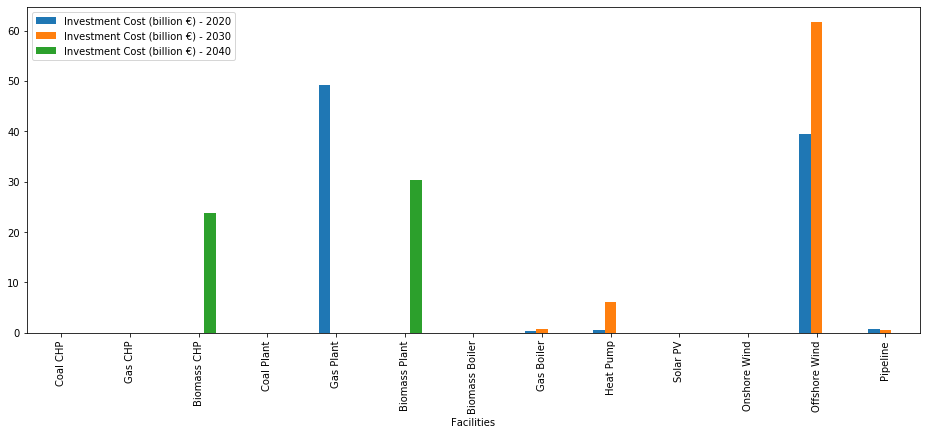

In [10]:
result_CHP_investment_cost_COAL = []
result_CHP_investment_cost_GAS = []
result_CHP_investment_cost_BIOMASS = []
result_ELEC_investment_cost_COAL = []
result_ELEC_investment_cost_GAS = []
result_ELEC_investment_cost_BIOMASS = []
result_HEAT_investment_cost_BIOMASS = []
result_HEAT_investment_cost_GAS = []
result_HP_investment_cost = []
result_SOLAR_investment_cost = []
result_ONSHORE_investment_cost = []
result_OFFSHORE_investment_cost = []
result_PIPE_investment_cost = []

for y in decades:
    result_CHP_investment_cost_COAL.append(sum(value(add_cap_chp[y][m][0])*facility_inv_cost[y][0]*interest_coef[y*10] for m in municipalities))
    result_CHP_investment_cost_GAS.append(sum(value(add_cap_chp[y][m][1])*facility_inv_cost[y][1]*interest_coef[y*10] for m in municipalities))
    result_CHP_investment_cost_BIOMASS.append(sum(value(add_cap_chp[y][m][2])*facility_inv_cost[y][2]*interest_coef[y*10] for m in municipalities))
    result_ELEC_investment_cost_COAL.append(value(add_cap_elec[y][3])*facility_inv_cost[y][3]*interest_coef[y*10])
    result_ELEC_investment_cost_GAS.append(value(add_cap_elec[y][4])*facility_inv_cost[y][4]*interest_coef[y*10])
    result_ELEC_investment_cost_BIOMASS.append(value(add_cap_elec[y][5])*facility_inv_cost[y][5]*interest_coef[y*10])
    result_HEAT_investment_cost_BIOMASS.append(sum(value(add_cap_heat[y][m][6])*facility_inv_cost[y][6]*interest_coef[y*10] for m in municipalities))
    result_HEAT_investment_cost_GAS.append(sum(value(add_cap_heat[y][m][7])*facility_inv_cost[y][7]*interest_coef[y*10] for m in municipalities))
    result_HP_investment_cost.append(sum(value(add_cap_hp[y][m])*facility_inv_cost[y][8]*interest_coef[y*10] for m in municipalities))
    result_SOLAR_investment_cost.append(value(add_cap_solar[y])*facility_inv_cost[y][9]*interest_coef[y*10])
    result_ONSHORE_investment_cost.append(value(add_cap_onshore[y])*facility_inv_cost[y][10]*interest_coef[y*10])
    result_OFFSHORE_investment_cost.append(value(add_cap_offshore[y])*facility_inv_cost[y][11]*interest_coef[y*10])
    result_PIPE_investment_cost.append(sum(value(add_pipe_cap[m][s][y])*unit_pipeline_cost_perkW*interest_coef[y*10]*distanceMatrix[m][s]*1000 for m in municipalities for s in neighbours_onlyIncludedMunis.iloc[m,1]) * 0.5)

result_investment_cost_df = pd.DataFrame(columns=["Facilities", "Investment Costs (€)"])
result_investment_cost_df["Facilities"] = ["Coal CHP", "Gas CHP", "Biomass CHP", "Coal Plant", "Gas Plant", "Biomass Plant", "Biomass Boiler", "Gas Boiler", "Heat Pump", "Solar PV", "Onshore Wind", "Offshore Wind", "Pipeline"]
#result_investment_cost_df["Facilities"] = ["Coal CHP", "Gas CHP", "Biomass CHP", "Coal Plant", "Gas Plant", "Biomass Plant", "Biomass Boiler", "Gas Boiler", "Heat Pump", "Solar PV", "Onshore Wind", "Offshore Wind"]
result_investment_cost_df.loc[0, "Investment Costs (€)"] = result_CHP_investment_cost_COAL
result_investment_cost_df.loc[1, "Investment Costs (€)"] = result_CHP_investment_cost_GAS
result_investment_cost_df.loc[2, "Investment Costs (€)"] = result_CHP_investment_cost_BIOMASS
result_investment_cost_df.loc[3, "Investment Costs (€)"] = result_ELEC_investment_cost_COAL
result_investment_cost_df.loc[4, "Investment Costs (€)"] = result_ELEC_investment_cost_GAS
result_investment_cost_df.loc[5, "Investment Costs (€)"] = result_ELEC_investment_cost_BIOMASS
result_investment_cost_df.loc[6, "Investment Costs (€)"] = result_HEAT_investment_cost_BIOMASS
result_investment_cost_df.loc[7, "Investment Costs (€)"] = result_HEAT_investment_cost_GAS
result_investment_cost_df.loc[8, "Investment Costs (€)"] = result_HP_investment_cost
result_investment_cost_df.loc[9, "Investment Costs (€)"] = result_SOLAR_investment_cost
result_investment_cost_df.loc[10, "Investment Costs (€)"] = result_ONSHORE_investment_cost
result_investment_cost_df.loc[11, "Investment Costs (€)"] = result_OFFSHORE_investment_cost
result_investment_cost_df.loc[12, "Investment Costs (€)"] = result_PIPE_investment_cost

for i in range(len(result_investment_cost_df)):
    result_investment_cost_df.loc[i, "Investment Cost (billion €) - 2020"] = result_investment_cost_df.loc[i, "Investment Costs (€)"][0] / 1000000000
    result_investment_cost_df.loc[i, "Investment Cost (billion €) - 2030"] = result_investment_cost_df.loc[i, "Investment Costs (€)"][1] / 1000000000
    result_investment_cost_df.loc[i, "Investment Cost (billion €) - 2040"] = result_investment_cost_df.loc[i, "Investment Costs (€)"][2] / 1000000000
    
    
ax = result_investment_cost_df.plot.bar(x="Facilities", figsize=[16,6])

fig = ax.get_figure()
fig.savefig(r'investmentCosts.png')

### OM Cost

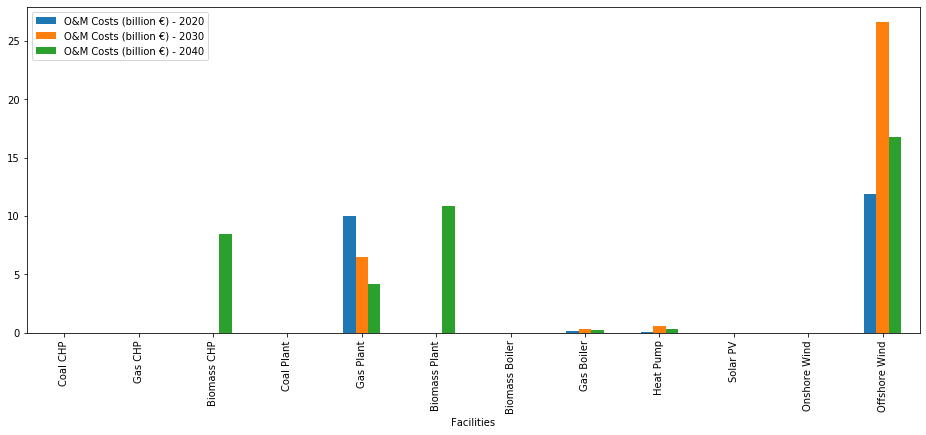

In [11]:
result_CHP_om_cost_COAL = []
result_CHP_om_cost_GAS = []
result_CHP_om_cost_BIOMASS = []
result_ELEC_om_cost_COAL = []
result_ELEC_om_cost_GAS = []
result_ELEC_om_cost_BIOMASS = []
result_HEAT_om_cost_BIOMASS = []
result_HEAT_om_cost_GAS = []
result_HP_om_cost = []
result_SOLAR_om_cost = []
result_ONSHORE_om_cost = []
result_OFFSHORE_om_cost = []

for y in decades:
    result_CHP_om_cost_COAL.append(sum(value(current_cap_chp[y][m][0]) *  facility_om_cost[y][0] * (sum(interest_coef[y*10:y*10+10])) for m in municipalities))
    result_CHP_om_cost_GAS.append(sum(value(current_cap_chp[y][m][1])  *  facility_om_cost[y][1] * (sum(interest_coef[y*10:y*10+10])) for m in municipalities))
    result_CHP_om_cost_BIOMASS.append(sum(value(current_cap_chp[y][m][2])  *  facility_om_cost[y][2] * (sum(interest_coef[y*10:y*10+10])) for m in municipalities))
    result_ELEC_om_cost_COAL.append(value(current_cap_elec[y][3]) *  facility_om_cost[y][3] * (sum(interest_coef[y*10:y*10+10])))
    result_ELEC_om_cost_GAS.append(value(current_cap_elec[y][4]) *  facility_om_cost[y][4] * (sum(interest_coef[y*10:y*10+10])))
    result_ELEC_om_cost_BIOMASS.append(value(current_cap_elec[y][5]) *  facility_om_cost[y][5] * (sum(interest_coef[y*10:y*10+10])))
    result_HEAT_om_cost_BIOMASS.append(sum(value(current_cap_heat[y][m][6]) *  facility_om_cost[y][6] * (sum(interest_coef[y*10:y*10+10])) for m in municipalities))
    result_HEAT_om_cost_GAS.append(sum(value(current_cap_heat[y][m][7]) *  facility_om_cost[y][7] * (sum(interest_coef[y*10:y*10+10])) for m in municipalities))
    result_HP_om_cost.append(sum(value(current_cap_hp[y][m]) *  facility_om_cost[y][8] * (sum(interest_coef[y*10:y*10+10])) for m in municipalities))
    result_SOLAR_om_cost.append(value(current_cap_solar[y]) *  facility_om_cost[y][9] * (sum(interest_coef[y*10:y*10+10])))
    result_ONSHORE_om_cost.append(value(current_cap_onshore[y]) *  facility_om_cost[y][10] * (sum(interest_coef[y*10:y*10+10])))
    result_OFFSHORE_om_cost.append(value(current_cap_offshore[y]) *  facility_om_cost[y][11] *  (sum(interest_coef[y*10:y*10+10])))

    
result_om_cost_df = pd.DataFrame(columns=["Facilities", "O&M Costs (€)"])
result_om_cost_df["Facilities"] = ["Coal CHP", "Gas CHP", "Biomass CHP", "Coal Plant", "Gas Plant", "Biomass Plant", "Biomass Boiler", "Gas Boiler", "Heat Pump", "Solar PV", "Onshore Wind", "Offshore Wind"]
result_om_cost_df.loc[0, "O&M Costs (€)"] = result_CHP_om_cost_COAL
result_om_cost_df.loc[1, "O&M Costs (€)"] = result_CHP_om_cost_GAS
result_om_cost_df.loc[2, "O&M Costs (€)"] = result_CHP_om_cost_BIOMASS
result_om_cost_df.loc[3, "O&M Costs (€)"] = result_ELEC_om_cost_COAL
result_om_cost_df.loc[4, "O&M Costs (€)"] = result_ELEC_om_cost_GAS
result_om_cost_df.loc[5, "O&M Costs (€)"] = result_ELEC_om_cost_BIOMASS
result_om_cost_df.loc[6, "O&M Costs (€)"] = result_HEAT_om_cost_BIOMASS
result_om_cost_df.loc[7, "O&M Costs (€)"] = result_HEAT_om_cost_GAS
result_om_cost_df.loc[8, "O&M Costs (€)"] = result_HP_om_cost
result_om_cost_df.loc[9, "O&M Costs (€)"] = result_SOLAR_om_cost
result_om_cost_df.loc[10, "O&M Costs (€)"] = result_ONSHORE_om_cost
result_om_cost_df.loc[11, "O&M Costs (€)"] = result_OFFSHORE_om_cost

for i in range(len(result_om_cost_df)):
    result_om_cost_df.loc[i, "O&M Costs (billion €) - 2020"] = result_om_cost_df.loc[i, "O&M Costs (€)"][0] / 1000000000
    result_om_cost_df.loc[i, "O&M Costs (billion €) - 2030"] = result_om_cost_df.loc[i, "O&M Costs (€)"][1] / 1000000000
    result_om_cost_df.loc[i, "O&M Costs (billion €) - 2040"] = result_om_cost_df.loc[i, "O&M Costs (€)"][2] / 1000000000
    
ax = result_om_cost_df.plot.bar(x="Facilities", figsize=[16,6])

fig = ax.get_figure()
fig.savefig(r'omCosts.png')

### Variable OM Cost

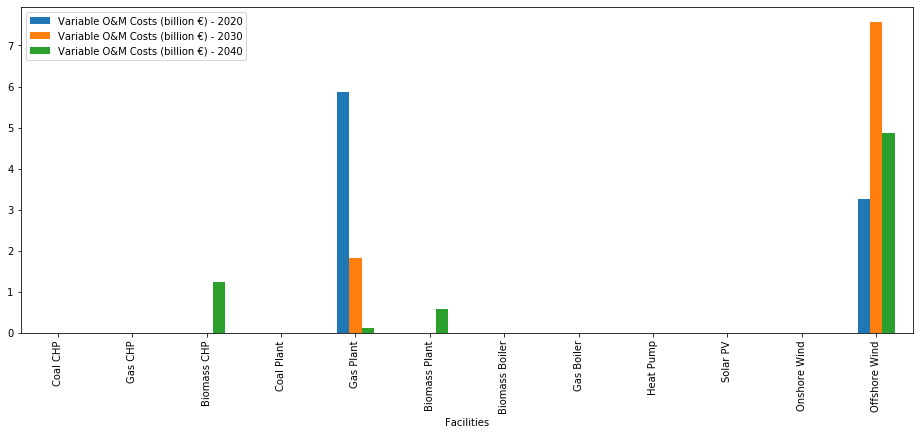

In [12]:
result_CHP_var_cost_COAL = []
result_CHP_var_cost_GAS = []
result_CHP_var_cost_BIOMASS = []
result_ELEC_var_cost_COAL = []
result_ELEC_var_cost_GAS = []
result_ELEC_var_cost_BIOMASS = []
result_HEAT_var_cost_BIOMASS = []
result_HEAT_var_cost_GAS = []
result_HP_var_cost = []
result_SOLAR_var_cost = []
result_ONSHORE_var_cost = []
result_OFFSHORE_var_cost = []

for y in decades:
    
    result_CHP_var_cost_COAL.append(sum(value(amount_fuel_chp[y][d][h][m][0])*facility_fuel_cv[0]*facility_elec_eff[0]*variable_om_cost[y][0]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours for m in municipalities))
    result_CHP_var_cost_GAS.append(sum(value(amount_fuel_chp[y][d][h][m][1])*facility_fuel_cv[1]*facility_elec_eff[1]*variable_om_cost[y][1]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours for m in municipalities))
    result_CHP_var_cost_BIOMASS.append(sum(value(amount_fuel_chp[y][d][h][m][2])*facility_fuel_cv[2]*facility_elec_eff[2]*variable_om_cost[y][2]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours for m in municipalities))
    result_ELEC_var_cost_COAL.append(sum(value(amount_fuel_elec[y][d][h][3])*facility_fuel_cv[3]*facility_elec_eff[3]*variable_om_cost[y][3]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours))
    result_ELEC_var_cost_GAS.append(sum(value(amount_fuel_elec[y][d][h][4])*facility_fuel_cv[4]*facility_elec_eff[4]*variable_om_cost[y][4]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours))
    result_ELEC_var_cost_BIOMASS.append(sum(value(amount_fuel_elec[y][d][h][5])*facility_fuel_cv[5]*facility_elec_eff[5]*variable_om_cost[y][5]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours))
    result_HEAT_var_cost_BIOMASS.append(sum(value(amount_fuel_heat[y][d][h][m][6])*facility_fuel_cv[6]*facility_thermal_eff[6]*variable_om_cost[y][6]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours for m in municipalities))
    result_HEAT_var_cost_GAS.append(sum(value(amount_fuel_heat[y][d][h][m][7])*facility_fuel_cv[7]*facility_thermal_eff[7]*variable_om_cost[y][7]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours for m in municipalities))
    result_HP_var_cost.append(sum(value(amount_electricity_hp[y][d][h][m])*facility_thermal_eff[8]*variable_om_cost[y][8]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours for m in municipalities))
    result_SOLAR_var_cost.append(sum(value(current_cap_solar[y])*solar_output_daily[y*9 + d][1][h]*variable_om_cost[y][9]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours))
    result_ONSHORE_var_cost.append(sum(value(current_cap_onshore[y])*onshore_output_daily[y*9 + d][1][h]*variable_om_cost[y][10]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours))
    result_OFFSHORE_var_cost.append(sum(value(current_cap_offshore[y])*offshore_output_daily[y*9 + d][1][h]*variable_om_cost[y][11]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours))
    
    
result_var_cost_df = pd.DataFrame(columns=["Facilities", "Variable O&M Costs (€)"])
result_var_cost_df["Facilities"] = ["Coal CHP", "Gas CHP", "Biomass CHP", "Coal Plant", "Gas Plant", "Biomass Plant", "Biomass Boiler", "Gas Boiler", "Heat Pump", "Solar PV", "Onshore Wind", "Offshore Wind"]
result_var_cost_df.loc[0, "Variable O&M Costs (€)"] = result_CHP_var_cost_COAL
result_var_cost_df.loc[1, "Variable O&M Costs (€)"] = result_CHP_var_cost_GAS
result_var_cost_df.loc[2, "Variable O&M Costs (€)"] = result_CHP_var_cost_BIOMASS
result_var_cost_df.loc[3, "Variable O&M Costs (€)"] = result_ELEC_var_cost_COAL
result_var_cost_df.loc[4, "Variable O&M Costs (€)"] = result_ELEC_var_cost_GAS
result_var_cost_df.loc[5, "Variable O&M Costs (€)"] = result_ELEC_var_cost_BIOMASS
result_var_cost_df.loc[6, "Variable O&M Costs (€)"] = result_HEAT_var_cost_BIOMASS
result_var_cost_df.loc[7, "Variable O&M Costs (€)"] = result_HEAT_var_cost_GAS
result_var_cost_df.loc[8, "Variable O&M Costs (€)"] = result_HP_var_cost
result_var_cost_df.loc[9, "Variable O&M Costs (€)"] = result_SOLAR_var_cost
result_var_cost_df.loc[10, "Variable O&M Costs (€)"] = result_ONSHORE_var_cost
result_var_cost_df.loc[11, "Variable O&M Costs (€)"] = result_OFFSHORE_var_cost

for i in range(len(result_var_cost_df)):
    result_var_cost_df.loc[i, "Variable O&M Costs (billion €) - 2020"] = result_var_cost_df.loc[i, "Variable O&M Costs (€)"][0] / 1000000000
    result_var_cost_df.loc[i, "Variable O&M Costs (billion €) - 2030"] = result_var_cost_df.loc[i, "Variable O&M Costs (€)"][1] / 1000000000
    result_var_cost_df.loc[i, "Variable O&M Costs (billion €) - 2040"] = result_var_cost_df.loc[i, "Variable O&M Costs (€)"][2] / 1000000000
    
ax = result_var_cost_df.plot.bar(x="Facilities", figsize=[16,6])

fig = ax.get_figure()
fig.savefig(r'vomCosts.png')

### Fuel cost

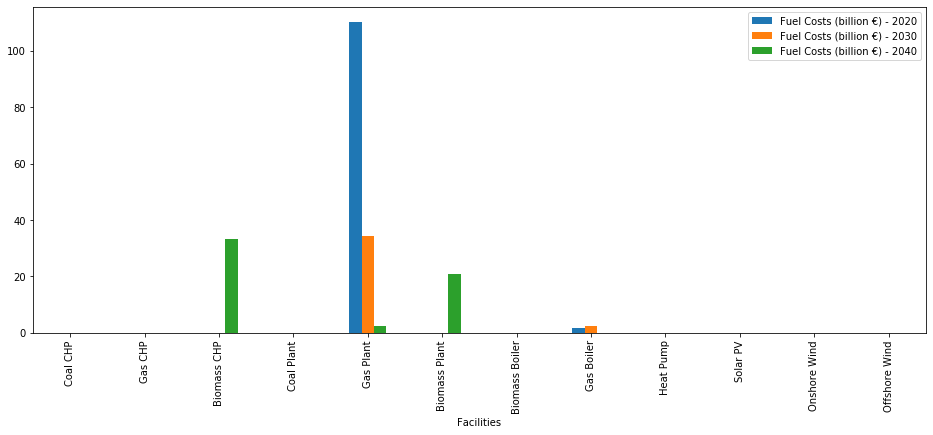

In [13]:
result_CHP_fuel_cost_COAL = []
result_CHP_fuel_cost_GAS = []
result_CHP_fuel_cost_BIOMASS = []
result_ELEC_fuel_cost_COAL = []
result_ELEC_fuel_cost_GAS = []
result_ELEC_fuel_cost_BIOMASS = []
result_HEAT_fuel_cost_BIOMASS = []
result_HEAT_fuel_cost_GAS = []
result_fuel_cost_HP = []
result_fuel_cost_SOLAR = []
result_fuel_cost_ONSHORE = []
result_fuel_cost_OFFSHORE = []

for y in decades:
    result_CHP_fuel_cost_COAL.append(sum(value(amount_fuel_chp[y][d][h][m][0])*facility_fuel_cost[0]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours for m in municipalities))
    result_CHP_fuel_cost_GAS.append(sum(value(amount_fuel_chp[y][d][h][m][1])*facility_fuel_cost[1]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours for m in municipalities))
    result_CHP_fuel_cost_BIOMASS.append(sum(value(amount_fuel_chp[y][d][h][m][2])*facility_fuel_cost[2]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours for m in municipalities))
    result_ELEC_fuel_cost_COAL.append(sum(value(amount_fuel_elec[y][d][h][3])*facility_fuel_cost[3]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours))
    result_ELEC_fuel_cost_GAS.append(sum(value(amount_fuel_elec[y][d][h][4])*facility_fuel_cost[4]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours))
    result_ELEC_fuel_cost_BIOMASS.append(sum(value(amount_fuel_elec[y][d][h][5])*facility_fuel_cost[5]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours))
    result_HEAT_fuel_cost_BIOMASS.append(sum(value(amount_fuel_heat[y][d][h][m][6])*facility_fuel_cost[6]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours for m in municipalities))
    result_HEAT_fuel_cost_GAS.append(sum(value(amount_fuel_heat[y][d][h][m][7])*facility_fuel_cost[7]*(rDaysFreq[rDays_idx[d]])*(interest_coef[(10*y) + 5]) for d in rDays for h in hours for m in municipalities))
    result_fuel_cost_HP.append(0)
    result_fuel_cost_SOLAR.append(0)
    result_fuel_cost_ONSHORE.append(0)
    result_fuel_cost_OFFSHORE.append(0)
    
result_fuel_cost_df = pd.DataFrame(columns=["Facilities", "Fuel Costs (€)"])
result_fuel_cost_df["Facilities"] = ["Coal CHP", "Gas CHP", "Biomass CHP", "Coal Plant", "Gas Plant", "Biomass Plant", "Biomass Boiler", "Gas Boiler",  "Heat Pump", "Solar PV", "Onshore Wind", "Offshore Wind"]
result_fuel_cost_df.loc[0, "Fuel Costs (€)"] = result_CHP_fuel_cost_COAL
result_fuel_cost_df.loc[1, "Fuel Costs (€)"] = result_CHP_fuel_cost_GAS
result_fuel_cost_df.loc[2, "Fuel Costs (€)"] = result_CHP_fuel_cost_BIOMASS
result_fuel_cost_df.loc[3, "Fuel Costs (€)"] = result_ELEC_fuel_cost_COAL
result_fuel_cost_df.loc[4, "Fuel Costs (€)"] = result_ELEC_fuel_cost_GAS
result_fuel_cost_df.loc[5, "Fuel Costs (€)"] = result_ELEC_fuel_cost_BIOMASS
result_fuel_cost_df.loc[6, "Fuel Costs (€)"] = result_HEAT_fuel_cost_BIOMASS
result_fuel_cost_df.loc[7, "Fuel Costs (€)"] = result_HEAT_fuel_cost_GAS
result_fuel_cost_df.loc[8, "Fuel Costs (€)"] = result_fuel_cost_HP
result_fuel_cost_df.loc[9, "Fuel Costs (€)"] = result_fuel_cost_SOLAR
result_fuel_cost_df.loc[10, "Fuel Costs (€)"] = result_fuel_cost_ONSHORE
result_fuel_cost_df.loc[11, "Fuel Costs (€)"] = result_fuel_cost_OFFSHORE

for i in range(len(result_fuel_cost_df)):
    result_fuel_cost_df.loc[i, "Fuel Costs (billion €) - 2020"] = result_fuel_cost_df.loc[i, "Fuel Costs (€)"][0] / 1000000000
    result_fuel_cost_df.loc[i, "Fuel Costs (billion €) - 2030"] = result_fuel_cost_df.loc[i, "Fuel Costs (€)"][1] / 1000000000
    result_fuel_cost_df.loc[i, "Fuel Costs (billion €) - 2040"] = result_fuel_cost_df.loc[i, "Fuel Costs (€)"][2] / 1000000000
    
ax = result_fuel_cost_df.plot.bar(x="Facilities", figsize=[16,6])

fig = ax.get_figure()
fig.savefig(r'fuelCosts.png')

### Costs aggregated !

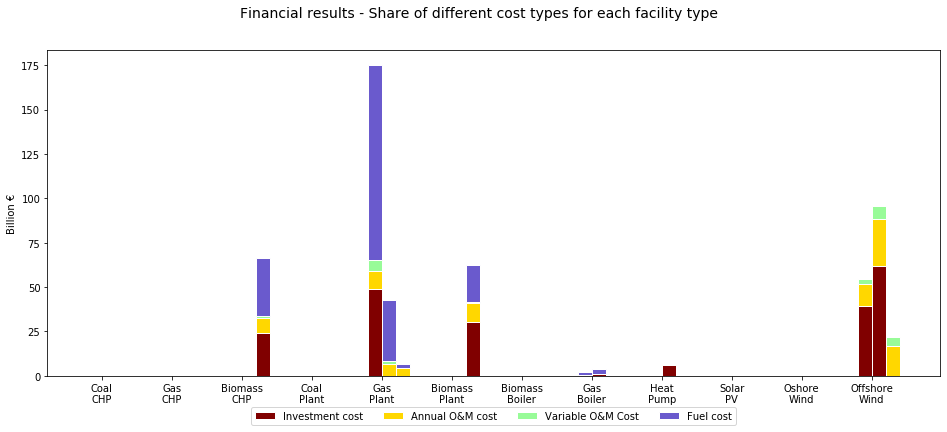

In [14]:
ind = np.arange(12)

list_investment_cost_2020 = list(result_investment_cost_df["Investment Cost (billion €) - 2020"])[:-1]
list_investment_cost_2030 = list(result_investment_cost_df["Investment Cost (billion €) - 2030"])[:-1]
list_investment_cost_2040 = list(result_investment_cost_df["Investment Cost (billion €) - 2040"])[:-1]

list_om_cost_2020 = list(result_om_cost_df["O&M Costs (billion €) - 2020"])
list_om_cost_2030 = list(result_om_cost_df["O&M Costs (billion €) - 2030"])
list_om_cost_2040 = list(result_om_cost_df["O&M Costs (billion €) - 2040"])

list_var_cost_2020 = list(result_var_cost_df["Variable O&M Costs (billion €) - 2020"])
list_var_cost_2030 = list(result_var_cost_df["Variable O&M Costs (billion €) - 2030"])
list_var_cost_2040 = list(result_var_cost_df["Variable O&M Costs (billion €) - 2040"])

list_fuel_cost_2020 = list(result_fuel_cost_df["Fuel Costs (billion €) - 2020"])
list_fuel_cost_2030 = list(result_fuel_cost_df["Fuel Costs (billion €) - 2030"])
list_fuel_cost_2040 = list(result_fuel_cost_df["Fuel Costs (billion €) - 2040"])

stack1_1 = np.add(list_investment_cost_2020,list_om_cost_2020).tolist()
stack1_2 = np.add(list_investment_cost_2030,list_om_cost_2030).tolist()
stack1_3 = np.add(list_investment_cost_2040,list_om_cost_2040).tolist()

stack2_1 = np.add(stack1_1,list_var_cost_2020).tolist()
stack2_2 = np.add(stack1_2,list_var_cost_2030).tolist()
stack2_3 = np.add(stack1_3,list_var_cost_2040).tolist()


# Create brown bars
plt.figure(figsize=(16,6))

width=0.2
p1_1= plt.bar(ind-width, list_investment_cost_2020, align="edge", width= width, edgecolor='white', color="maroon")
p1_2= plt.bar(ind, list_investment_cost_2030, align="edge", width= width, edgecolor='white', color="maroon")
p1_3= plt.bar(ind+width, list_investment_cost_2040, align="edge", width= width, edgecolor='white', color="maroon" )

p2_1= plt.bar(ind-width, list_om_cost_2020, align="edge", bottom= list_investment_cost_2020, width= width, edgecolor='white',color="gold")
p2_2= plt.bar(ind, list_om_cost_2030, align="edge",  bottom= list_investment_cost_2030, width= width, edgecolor='white',color="gold")
p2_3= plt.bar(ind+width, list_om_cost_2040, align="edge",  bottom= list_investment_cost_2040, width= width, edgecolor='white',color="gold")

p3_1= plt.bar(ind-width, list_var_cost_2020, align="edge", bottom= stack1_1, width= width, edgecolor='white',color="palegreen")
p3_2= plt.bar(ind, list_var_cost_2030, align="edge",  bottom= stack1_2, width= width, edgecolor='white',color="palegreen")
p3_3= plt.bar(ind+width, list_var_cost_2040, align="edge",  bottom= stack1_3, width= width, edgecolor='white',color="palegreen")

p4_1= plt.bar(ind-width, list_fuel_cost_2020, align="edge", bottom= stack2_1, width= width, edgecolor='white',color="slateblue")
p4_2= plt.bar(ind, list_fuel_cost_2030, align="edge",  bottom= stack2_2, width= width, edgecolor='white',color="slateblue")
p4_3= plt.bar(ind+width, list_fuel_cost_2040, align="edge",  bottom= stack2_3, width= width, edgecolor='white',color="slateblue")

#plt.xticks(ind, fontweight='bold')

tickLabels=["Coal\nCHP", "Gas\nCHP", "Biomass\nCHP", "Coal\nPlant", "Gas\nPlant", "Biomass\nPlant", "Biomass\nBoiler", "Gas\nBoiler", "Heat\nPump", "Solar\nPV", "Oshore\nWind", "Offshore\nWind", ]
plt.xticks(ind, tickLabels)
#plt.xlabel("Facility types")
plt.ylabel("Billion €")
plt.legend((p1_1[0],p2_1[0],p3_1[0], p4_1[0]), ("Investment cost", "Annual O&M cost", "Variable O&M Cost", "Fuel cost"), loc='upper center', bbox_to_anchor=(0.5, -0.08),
          ncol=10, fancybox=True)
plt.suptitle('Financial results - Share of different cost types for each facility type', fontsize=14)
# Show graphic
plt.savefig(r'financial_results.png')
plt.show()


### Electricity Generation Mix

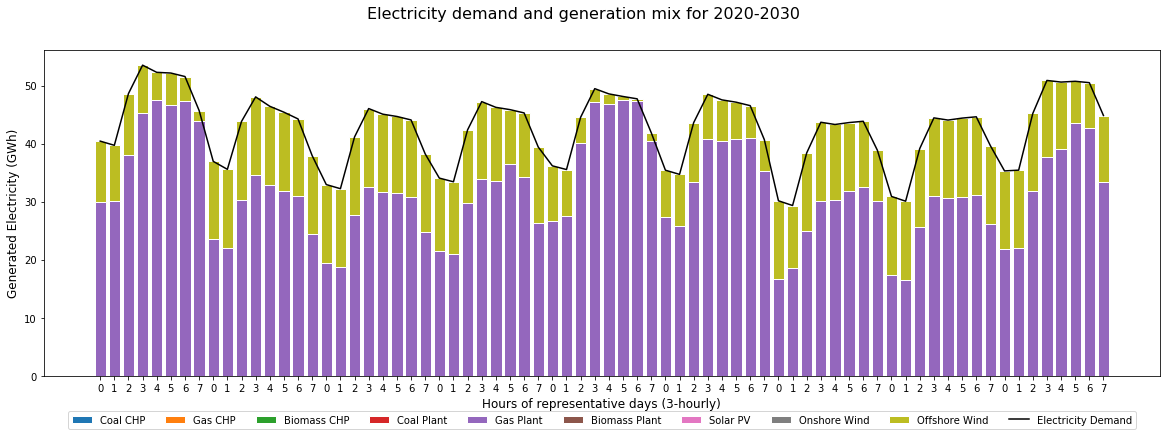

In [15]:
# in GWh
result_generated_electricity_df = pd.DataFrame(columns=["Coal CHP", "Gas CHP", "Biomass CHP", "Coal Plant", "Gas Plant", "Biomass Plant", "Solar PV", "Onshore Wind", "Offshore Wind"])

for y in decades:
    for d in rDays:
        for h in hours:
            result_generated_electricity_df.loc[y*72 + d*8 + h, "Coal CHP"] = sum(value(amount_fuel_chp[y][d][h][m][0])*facility_fuel_cv[0]*facility_elec_eff[0] for m in municipalities) / 1000000
            result_generated_electricity_df.loc[y*72 + d*8 + h, "Gas CHP"] = sum(value(amount_fuel_chp[y][d][h][m][1])*facility_fuel_cv[1]*facility_elec_eff[1] for m in municipalities) / 1000000
            result_generated_electricity_df.loc[y*72 + d*8 + h, "Biomass CHP"] = sum(value(amount_fuel_chp[y][d][h][m][2])*facility_fuel_cv[2]*facility_elec_eff[2] for m in municipalities) / 1000000
            result_generated_electricity_df.loc[y*72 + d*8 + h, "Coal Plant"] = value(amount_fuel_elec[y][d][h][3])*facility_fuel_cv[3]*facility_elec_eff[3] / 1000000
            result_generated_electricity_df.loc[y*72 + d*8 + h, "Gas Plant"] = value(amount_fuel_elec[y][d][h][4])*facility_fuel_cv[4]*facility_elec_eff[4] / 1000000
            result_generated_electricity_df.loc[y*72 + d*8 + h, "Biomass Plant"] = value(amount_fuel_elec[y][d][h][5])*facility_fuel_cv[5]*facility_elec_eff[5] / 1000000
            result_generated_electricity_df.loc[y*72 + d*8 + h, "Solar PV"] = value(current_cap_solar[y])*solar_output_daily[y*9 + d][1][h] / 1000000
            result_generated_electricity_df.loc[y*72 + d*8 + h, "Onshore Wind"] = value(current_cap_onshore[y])*onshore_output_daily[y*9 + d][1][h] / 1000000
            result_generated_electricity_df.loc[y*72 + d*8 + h, "Offshore Wind"] = value(current_cap_offshore[y])*offshore_output_daily[y*9 + d][1][h] / 1000000

bar_coal_CHP = list(result_generated_electricity_df["Coal CHP"])[:72]
bar_gas_CHP = list(result_generated_electricity_df["Gas CHP"])[:72]
bar_biomass_CHP = list(result_generated_electricity_df["Biomass CHP"])[:72]
bar_coal_plant = list(result_generated_electricity_df["Coal Plant"])[:72]
bar_gas_plant = list(result_generated_electricity_df["Gas Plant"])[:72]
bar_biomass_plant = list(result_generated_electricity_df["Biomass Plant"])[:72]
bar_solar_pv = list(result_generated_electricity_df["Solar PV"])[:72]
bar_onshore_wind = list(result_generated_electricity_df["Onshore Wind"])[:72]
bar_offshore_wind = list(result_generated_electricity_df["Offshore Wind"])[:72]
order = [40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,0,1,2,3,4,5,6,7,16,17,18,19,20,21,22,23,64,65,66,67,68,69,70,71,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,8,9,10,11,12,13,14,15,56,57,58,59,60,61,62,63]
bar_coal_CHP = [bar_coal_CHP[i] for i in order]
bar_gas_CHP = [bar_gas_CHP[i] for i in order]
bar_biomass_CHP = [bar_biomass_CHP[i] for i in order]
bar_coal_plant = [bar_coal_plant[i] for i in order]
bar_gas_plant = [bar_gas_plant[i] for i in order]
bar_biomass_plant = [bar_biomass_plant[i] for i in order]
bar_solar_pv = [bar_solar_pv[i] for i in order]
bar_onshore_wind = [bar_onshore_wind[i] for i in order]
bar_offshore_wind = [bar_offshore_wind[i] for i in order]


heatPump_ElecDemand=[]
for y in decades:
    for d in rDays:
        for h in hours:
            # in GWh
            heatPump_ElecDemand.append(sum(value(amount_electricity_hp[y][d][h][m]) for m in municipalities) / 1000000)
            

electricity_load_list = []
for i in range(len(electricity_load_daily_db)):
    electricity_load_list.extend(electricity_load_daily_db.loc[i,"Value"])

# to GWh
electricity_load_list = list(pd.Series(electricity_load_list) / 1000000)
electricity_load_list = np.add(electricity_load_list, heatPump_ElecDemand).tolist()

electricity_load_list = electricity_load_list[:72]
electricity_load_list = [electricity_load_list[i] for i in order]

bars1 = np.add(bar_coal_CHP, bar_gas_CHP).tolist()
bars2 = np.add(bars1, bar_biomass_CHP).tolist()
bars3 = np.add(bars2, bar_coal_plant).tolist()
bars4 = np.add(bars3, bar_gas_plant).tolist()
bars5 = np.add(bars4, bar_biomass_plant).tolist()
bars6 = np.add(bars5, bar_solar_pv).tolist()
bars7 = np.add(bars6, bar_onshore_wind).tolist()

r = list(range(len(bar_coal_CHP)))

# Create brown bars
plt.figure(figsize=(20,6))


p1= plt.bar(r, bar_coal_CHP, edgecolor='white')
p2= plt.bar(r, bar_gas_CHP, bottom=bar_coal_CHP, edgecolor='white')
p3= plt.bar(r, bar_biomass_CHP, bottom=bars1, edgecolor='white')
p4= plt.bar(r, bar_coal_plant, bottom=bars2, edgecolor='white')
p5= plt.bar(r, bar_gas_plant, bottom=bars3, edgecolor='white')
p6= plt.bar(r, bar_biomass_plant, bottom=bars4, edgecolor='white')
p7= plt.bar(r, bar_solar_pv, bottom=bars5, edgecolor='white')
p8= plt.bar(r, bar_onshore_wind, bottom=bars6, edgecolor='white')
p9= plt.bar(r, bar_offshore_wind, bottom=bars7, edgecolor='white')
p10= plt.plot(electricity_load_list, color="black")


# Custom X axis
xTickList = ["0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7"]
plt.xticks(r, xTickList)
plt.xlabel("Hours of representative days (3-hourly)", fontsize=12)
plt.ylabel("Generated Electricity (GWh)", fontsize=12)
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0], p10[0]), ("Coal CHP", "Gas CHP", "Biomass CHP", "Coal Plant", "Gas Plant", "Biomass Plant", "Solar PV", "Onshore Wind", "Offshore Wind", "Electricity Demand"), loc='upper center', bbox_to_anchor=(0.5, -0.0920),
          ncol=10, fancybox=True)
plt.suptitle('Electricity demand and generation mix for 2020-2030', fontsize=16)
# Show graphic

plt.savefig(r'elec_genMix2020.png')
plt.show()

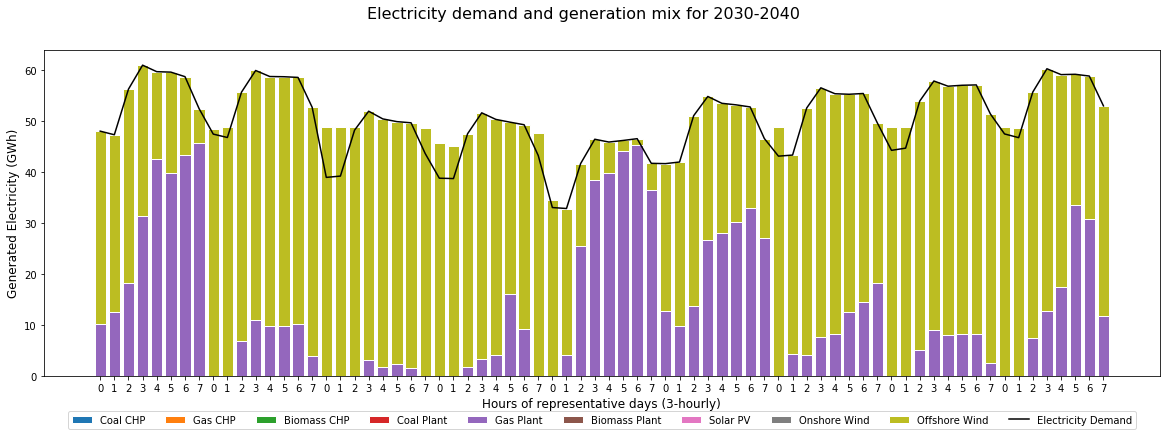

In [16]:
bar_coal_CHP = list(result_generated_electricity_df["Coal CHP"])[72:144]
bar_gas_CHP = list(result_generated_electricity_df["Gas CHP"])[72:144]
bar_biomass_CHP = list(result_generated_electricity_df["Biomass CHP"])[72:144]
bar_coal_plant = list(result_generated_electricity_df["Coal Plant"])[72:144]
bar_gas_plant = list(result_generated_electricity_df["Gas Plant"])[72:144]
bar_biomass_plant = list(result_generated_electricity_df["Biomass Plant"])[72:144]
bar_solar_pv = list(result_generated_electricity_df["Solar PV"])[72:144]
bar_onshore_wind = list(result_generated_electricity_df["Onshore Wind"])[72:144]
bar_offshore_wind = list(result_generated_electricity_df["Offshore Wind"])[72:144]
order = [40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,0,1,2,3,4,5,6,7,16,17,18,19,20,21,22,23,64,65,66,67,68,69,70,71,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,8,9,10,11,12,13,14,15,56,57,58,59,60,61,62,63]
bar_coal_CHP = [bar_coal_CHP[i] for i in order]
bar_gas_CHP = [bar_gas_CHP[i] for i in order]
bar_biomass_CHP = [bar_biomass_CHP[i] for i in order]
bar_coal_plant = [bar_coal_plant[i] for i in order]
bar_gas_plant = [bar_gas_plant[i] for i in order]
bar_biomass_plant = [bar_biomass_plant[i] for i in order]
bar_solar_pv = [bar_solar_pv[i] for i in order]
bar_onshore_wind = [bar_onshore_wind[i] for i in order]
bar_offshore_wind = [bar_offshore_wind[i] for i in order]


heatPump_ElecDemand=[]
for y in decades:
    for d in rDays:
        for h in hours:
            # in GWh
            heatPump_ElecDemand.append(sum(value(amount_electricity_hp[y][d][h][m]) for m in municipalities) / 1000000)
            

electricity_load_list = []
for i in range(len(electricity_load_daily_db)):
    electricity_load_list.extend(electricity_load_daily_db.loc[i,"Value"])

# to GWh
electricity_load_list = list(pd.Series(electricity_load_list) / 1000000)
electricity_load_list = np.add(electricity_load_list, heatPump_ElecDemand).tolist()

electricity_load_list = electricity_load_list[72:144]
electricity_load_list = [electricity_load_list[i] for i in order]

bars1 = np.add(bar_coal_CHP, bar_gas_CHP).tolist()
bars2 = np.add(bars1, bar_biomass_CHP).tolist()
bars3 = np.add(bars2, bar_coal_plant).tolist()
bars4 = np.add(bars3, bar_gas_plant).tolist()
bars5 = np.add(bars4, bar_biomass_plant).tolist()
bars6 = np.add(bars5, bar_solar_pv).tolist()
bars7 = np.add(bars6, bar_onshore_wind).tolist()

r = list(range(len(bar_coal_CHP)))


# Create brown bars
plt.figure(figsize=(20,6))

p1= plt.bar(r, bar_coal_CHP, edgecolor='white')
p2= plt.bar(r, bar_gas_CHP, bottom=bar_coal_CHP, edgecolor='white')
p3= plt.bar(r, bar_biomass_CHP, bottom=bars1, edgecolor='white')
p4= plt.bar(r, bar_coal_plant, bottom=bars2, edgecolor='white')
p5= plt.bar(r, bar_gas_plant, bottom=bars3, edgecolor='white')
p6= plt.bar(r, bar_biomass_plant, bottom=bars4, edgecolor='white')
p7= plt.bar(r, bar_solar_pv, bottom=bars5, edgecolor='white')
p8= plt.bar(r, bar_onshore_wind, bottom=bars6, edgecolor='white')
p9= plt.bar(r, bar_offshore_wind, bottom=bars7, edgecolor='white')
p10= plt.plot(electricity_load_list, color="black")

# Custom X axis
xTickList = ["0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7"]
plt.xticks(r, xTickList)
plt.xlabel("Hours of representative days (3-hourly)", fontsize=12)
plt.ylabel("Generated Electricity (GWh)", fontsize=12)
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0], p10[0]), ("Coal CHP", "Gas CHP", "Biomass CHP", "Coal Plant", "Gas Plant", "Biomass Plant", "Solar PV", "Onshore Wind", "Offshore Wind", "Electricity Demand"), loc='upper center', bbox_to_anchor=(0.5, -0.0920),
          ncol=10, fancybox=True)
plt.suptitle('Electricity demand and generation mix for 2030-2040', fontsize=16)
# Show graphic
plt.savefig(r'elec_genMix2030.png')
plt.show()


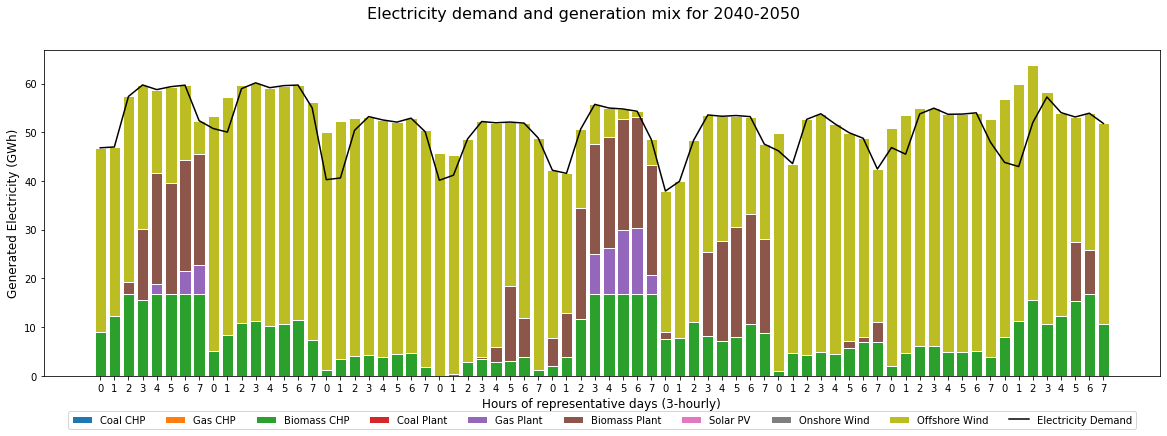

In [17]:
bar_coal_CHP = list(result_generated_electricity_df["Coal CHP"])[144:]
bar_gas_CHP = list(result_generated_electricity_df["Gas CHP"])[144:]
bar_biomass_CHP = list(result_generated_electricity_df["Biomass CHP"])[144:]
bar_coal_plant = list(result_generated_electricity_df["Coal Plant"])[144:]
bar_gas_plant = list(result_generated_electricity_df["Gas Plant"])[144:]
bar_biomass_plant = list(result_generated_electricity_df["Biomass Plant"])[144:]
bar_solar_pv = list(result_generated_electricity_df["Solar PV"])[144:]
bar_onshore_wind = list(result_generated_electricity_df["Onshore Wind"])[144:]
bar_offshore_wind = list(result_generated_electricity_df["Offshore Wind"])[144:]
order = [40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,0,1,2,3,4,5,6,7,16,17,18,19,20,21,22,23,64,65,66,67,68,69,70,71,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,8,9,10,11,12,13,14,15,56,57,58,59,60,61,62,63]
bar_coal_CHP = [bar_coal_CHP[i] for i in order]
bar_gas_CHP = [bar_gas_CHP[i] for i in order]
bar_biomass_CHP = [bar_biomass_CHP[i] for i in order]
bar_coal_plant = [bar_coal_plant[i] for i in order]
bar_gas_plant = [bar_gas_plant[i] for i in order]
bar_biomass_plant = [bar_biomass_plant[i] for i in order]
bar_solar_pv = [bar_solar_pv[i] for i in order]
bar_onshore_wind = [bar_onshore_wind[i] for i in order]
bar_offshore_wind = [bar_offshore_wind[i] for i in order]

heatPump_ElecDemand=[]
for y in decades:
    for d in rDays:
        for h in hours:
            # in GWh
            heatPump_ElecDemand.append(sum(value(amount_electricity_hp[y][d][h][m]) for m in municipalities) / 1000000)
            

electricity_load_list = []
for i in range(len(electricity_load_daily_db)):
    electricity_load_list.extend(electricity_load_daily_db.loc[i,"Value"])

# to GWh
electricity_load_list = list(pd.Series(electricity_load_list) / 1000000)
electricity_load_list = np.add(electricity_load_list, heatPump_ElecDemand).tolist()
electricity_load_list = electricity_load_list[144:]
electricity_load_list = [electricity_load_list[i] for i in order]

bars1 = np.add(bar_coal_CHP, bar_gas_CHP).tolist()
bars2 = np.add(bars1, bar_biomass_CHP).tolist()
bars3 = np.add(bars2, bar_coal_plant).tolist()
bars4 = np.add(bars3, bar_gas_plant).tolist()
bars5 = np.add(bars4, bar_biomass_plant).tolist()
bars6 = np.add(bars5, bar_solar_pv).tolist()
bars7 = np.add(bars6, bar_onshore_wind).tolist()

r = list(range(len(bar_coal_CHP)))


# Create brown bars
plt.figure(figsize=(20,6))

p1= plt.bar(r, bar_coal_CHP, edgecolor='white')
p2= plt.bar(r, bar_gas_CHP, bottom=bar_coal_CHP, edgecolor='white')
p3= plt.bar(r, bar_biomass_CHP, bottom=bars1, edgecolor='white')
p4= plt.bar(r, bar_coal_plant, bottom=bars2, edgecolor='white')
p5= plt.bar(r, bar_gas_plant, bottom=bars3, edgecolor='white')
p6= plt.bar(r, bar_biomass_plant, bottom=bars4, edgecolor='white')
p7= plt.bar(r, bar_solar_pv, bottom=bars5, edgecolor='white')
p8= plt.bar(r, bar_onshore_wind, bottom=bars6, edgecolor='white')
p9= plt.bar(r, bar_offshore_wind, bottom=bars7, edgecolor='white')
p10= plt.plot(electricity_load_list, color="black")

# Custom X axis
xTickList = ["0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7"]
plt.xticks(r, xTickList)
plt.xlabel("Hours of representative days (3-hourly)", fontsize=12)
plt.ylabel("Generated Electricity (GWh)", fontsize=12)
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0],p8[0],p9[0], p10[0]), ("Coal CHP", "Gas CHP", "Biomass CHP", "Coal Plant", "Gas Plant", "Biomass Plant", "Solar PV", "Onshore Wind", "Offshore Wind", "Electricity Demand"), loc='upper center', bbox_to_anchor=(0.5, -0.0920),
          ncol=10, fancybox=True)
plt.suptitle('Electricity demand and generation mix for 2040-2050', fontsize=16)
# Show graphic

plt.savefig(r'elec_genMix2040.png')
plt.show()


### Heat Generation Mix

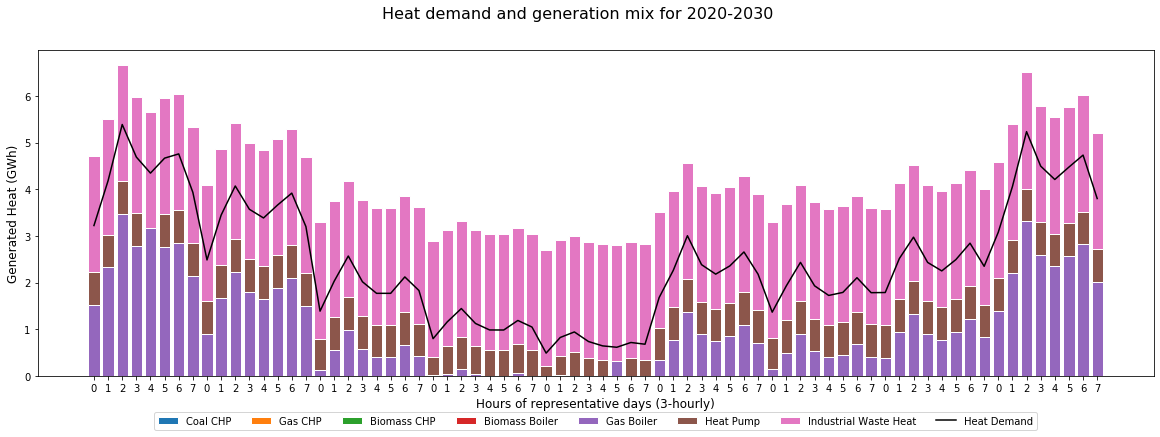

In [18]:
# in GWh
result_generated_heat_df = pd.DataFrame(columns=["Coal CHP", "Gas CHP", "Biomass CHP", "Biomass Boiler", "Gas Boiler", "Heat Pump", "Industrial Waste Heat"])

for y in decades:
    for d in rDays:
        for h in hours:
            result_generated_heat_df.loc[y*72 + d*8 + h, "Demand"] = sum(heat_demand_daily[y*9 + d][m+1][h]*dh_share_data[y][m] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Coal CHP"] = sum(value(amount_fuel_chp[y][d][h][m][0])*facility_fuel_cv[0]*facility_thermal_eff[0] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Gas CHP"] = sum(value(amount_fuel_chp[y][d][h][m][1])*facility_fuel_cv[1]*facility_thermal_eff[1] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Biomass CHP"] = sum(value(amount_fuel_chp[y][d][h][m][2])*facility_fuel_cv[2]*facility_thermal_eff[2] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Biomass Boiler"] = sum(value(amount_fuel_heat[y][d][h][m][6])*facility_fuel_cv[6]*facility_thermal_eff[6] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Gas Boiler"] = sum(value(amount_fuel_heat[y][d][h][m][7])*facility_fuel_cv[7]*facility_thermal_eff[7] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Heat Pump"] = sum(value(amount_electricity_hp[y][d][h][m])*facility_thermal_eff[8] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Industrial Waste Heat"] = sum(wasteHeatfromIndustryMatrix[0][m] for m in municipalities) / 1000000


bar_waste_heat = list(result_generated_heat_df["Industrial Waste Heat"])[:72]
bar_coal_CHP = list(result_generated_heat_df["Coal CHP"])[:72]
bar_gas_CHP = list(result_generated_heat_df["Gas CHP"])[:72]
bar_biomass_CHP = list(result_generated_heat_df["Biomass CHP"])[:72]
bar_biomass_boiler = list(result_generated_heat_df["Biomass Boiler"])[:72]
bar_gas_boiler = list(result_generated_heat_df["Gas Boiler"])[:72]
bar_heat_pump = list(result_generated_heat_df["Heat Pump"])[:72]
heat_load_list = list(result_generated_heat_df["Demand"])[:72]
order = [40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,0,1,2,3,4,5,6,7,16,17,18,19,20,21,22,23,64,65,66,67,68,69,70,71,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,8,9,10,11,12,13,14,15,56,57,58,59,60,61,62,63]

bar_waste_heat = [bar_waste_heat[i] for i in order]
bar_coal_CHP = [bar_coal_CHP[i] for i in order]
bar_gas_CHP = [bar_gas_CHP[i] for i in order]
bar_biomass_CHP = [bar_biomass_CHP[i] for i in order]
bar_biomass_boiler = [bar_biomass_boiler[i] for i in order]
bar_gas_boiler = [bar_gas_boiler[i] for i in order]
bar_heat_pump = [bar_heat_pump[i] for i in order]
heat_load_list = [heat_load_list[i] for i in order]

bars1 = np.add(bar_coal_CHP, bar_gas_CHP).tolist()
bars2 = np.add(bars1, bar_biomass_CHP).tolist()
bars3 = np.add(bars2, bar_biomass_boiler).tolist()
bars4 = np.add(bars3, bar_gas_boiler).tolist()
bars5 = np.add(bars4, bar_heat_pump).tolist()
bars6 = np.add(bars5, bar_waste_heat).tolist()

r = list(range(len(bar_coal_CHP)))


# Create brown bars
plt.figure(figsize=(20,6))

p1= plt.bar(r, bar_coal_CHP, edgecolor='white')
p2= plt.bar(r, bar_gas_CHP, bottom=bar_coal_CHP, edgecolor='white')
p3= plt.bar(r, bar_biomass_CHP, bottom=bars1, edgecolor='white')
p4= plt.bar(r, bar_biomass_boiler, bottom=bars2, edgecolor='white')
p5= plt.bar(r, bar_gas_boiler, bottom=bars3, edgecolor='white')
p6= plt.bar(r, bar_heat_pump, bottom=bars4, edgecolor='white')
p7= plt.bar(r, bar_waste_heat, bottom=bars5, edgecolor='white')
p8= plt.plot(heat_load_list, color="black")

# Custom X axis

xTickList = ["0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7"]
plt.xticks(r, xTickList)
plt.xlabel("Hours of representative days (3-hourly)", fontsize=12)
plt.ylabel("Generated Heat (GWh)", fontsize=12)
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0], p8[0]), ("Coal CHP", "Gas CHP", "Biomass CHP", "Biomass Boiler", "Gas Boiler", "Heat Pump", "Industrial Waste Heat", "Heat Demand"), loc='upper center', bbox_to_anchor=(0.5, -0.0950),
          ncol=8, fancybox=True)
plt.suptitle('Heat demand and generation mix for 2020-2030', fontsize=16)
# Show graphic
plt.savefig(r'heat_genMix_2020.png')
plt.show()

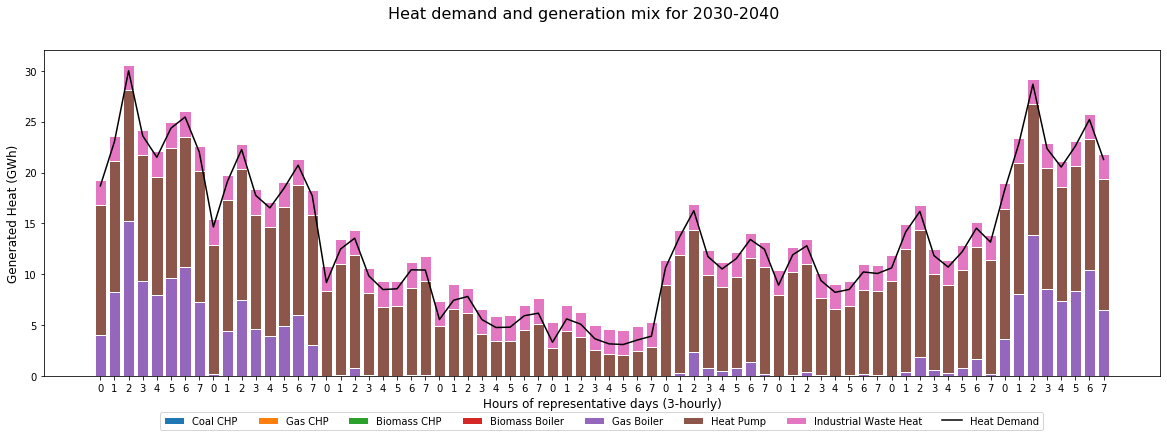

In [19]:
# in GWh
result_generated_heat_df = pd.DataFrame(columns=["Coal CHP", "Gas CHP", "Biomass CHP", "Biomass Boiler", "Gas Boiler", "Heat Pump", "Industrial Waste Heat"])

for y in decades:
    for d in rDays:
        for h in hours:
            result_generated_heat_df.loc[y*72 + d*8 + h, "Demand"] = sum(heat_demand_daily[y*9 + d][m+1][h]*dh_share_data[y][m] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Coal CHP"] = sum(value(amount_fuel_chp[y][d][h][m][0])*facility_fuel_cv[0]*facility_thermal_eff[0] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Gas CHP"] = sum(value(amount_fuel_chp[y][d][h][m][1])*facility_fuel_cv[1]*facility_thermal_eff[1] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Biomass CHP"] = sum(value(amount_fuel_chp[y][d][h][m][2])*facility_fuel_cv[2]*facility_thermal_eff[2] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Biomass Boiler"] = sum(value(amount_fuel_heat[y][d][h][m][6])*facility_fuel_cv[6]*facility_thermal_eff[6] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Gas Boiler"] = sum(value(amount_fuel_heat[y][d][h][m][7])*facility_fuel_cv[7]*facility_thermal_eff[7] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Heat Pump"] = sum(value(amount_electricity_hp[y][d][h][m])*facility_thermal_eff[8] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Industrial Waste Heat"] = sum(wasteHeatfromIndustryMatrix[0][m] for m in municipalities) / 1000000

bar_waste_heat = list(result_generated_heat_df["Industrial Waste Heat"])[72:144]
bar_coal_CHP = list(result_generated_heat_df["Coal CHP"])[72:144]
bar_gas_CHP = list(result_generated_heat_df["Gas CHP"])[72:144]
bar_biomass_CHP = list(result_generated_heat_df["Biomass CHP"])[72:144]
bar_biomass_boiler = list(result_generated_heat_df["Biomass Boiler"])[72:144]
bar_gas_boiler = list(result_generated_heat_df["Gas Boiler"])[72:144]
bar_heat_pump = list(result_generated_heat_df["Heat Pump"])[72:144]
heat_load_list = list(result_generated_heat_df["Demand"])[72:144]
order = [40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,0,1,2,3,4,5,6,7,16,17,18,19,20,21,22,23,64,65,66,67,68,69,70,71,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,8,9,10,11,12,13,14,15,56,57,58,59,60,61,62,63]
bar_waste_heat = [bar_waste_heat[i] for i in order]
bar_coal_CHP = [bar_coal_CHP[i] for i in order]
bar_gas_CHP = [bar_gas_CHP[i] for i in order]
bar_biomass_CHP = [bar_biomass_CHP[i] for i in order]
bar_biomass_boiler = [bar_biomass_boiler[i] for i in order]
bar_gas_boiler = [bar_gas_boiler[i] for i in order]
bar_heat_pump = [bar_heat_pump[i] for i in order]
heat_load_list = [heat_load_list[i] for i in order]

bars1 = np.add(bar_coal_CHP, bar_gas_CHP).tolist()
bars2 = np.add(bars1, bar_biomass_CHP).tolist()
bars3 = np.add(bars2, bar_biomass_boiler).tolist()
bars4 = np.add(bars3, bar_gas_boiler).tolist()
bars5 = np.add(bars4, bar_heat_pump).tolist()
bars6 = np.add(bars5, bar_waste_heat).tolist()

r = list(range(len(bar_coal_CHP)))


# Create brown bars
plt.figure(figsize=(20,6))

p1= plt.bar(r, bar_coal_CHP, edgecolor='white')
p2= plt.bar(r, bar_gas_CHP, bottom=bar_coal_CHP, edgecolor='white')
p3= plt.bar(r, bar_biomass_CHP, bottom=bars1, edgecolor='white')
p4= plt.bar(r, bar_biomass_boiler, bottom=bars2, edgecolor='white')
p5= plt.bar(r, bar_gas_boiler, bottom=bars3, edgecolor='white')
p6= plt.bar(r, bar_heat_pump, bottom=bars4, edgecolor='white')
p7= plt.bar(r, bar_waste_heat, bottom=bars5, edgecolor='white')
p8= plt.plot(heat_load_list, color="black")

# Custom X axis

xTickList = ["0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7"]
plt.xticks(r, xTickList)
plt.xlabel("Hours of representative days (3-hourly)", fontsize=12)
plt.ylabel("Generated Heat (GWh)", fontsize=12)
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0], p8[0]), ("Coal CHP", "Gas CHP", "Biomass CHP", "Biomass Boiler", "Gas Boiler", "Heat Pump", "Industrial Waste Heat", "Heat Demand"), loc='upper center', bbox_to_anchor=(0.5, -0.0950),
          ncol=8, fancybox=True)
plt.suptitle('Heat demand and generation mix for 2030-2040', fontsize=16)
# Show graphic

plt.savefig(r'heat_genMix_2030.png')
plt.show()

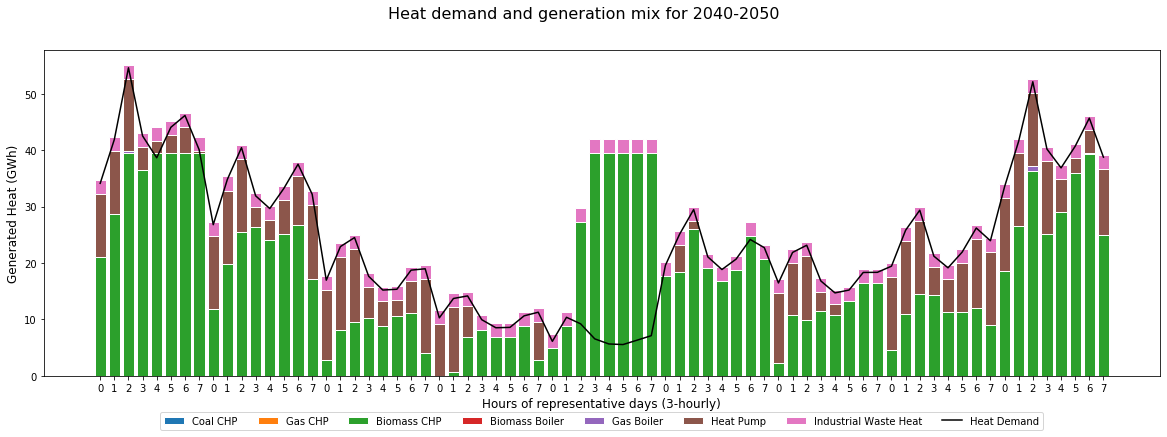

In [20]:
# in GWh
result_generated_heat_df = pd.DataFrame(columns=["Coal CHP", "Gas CHP", "Biomass CHP", "Biomass Boiler", "Gas Boiler", "Heat Pump", "Industrial Waste Heat"])

for y in decades:
    for d in rDays:
        for h in hours:
            result_generated_heat_df.loc[y*72 + d*8 + h, "Demand"] = sum(heat_demand_daily[y*9 + d][m+1][h]*dh_share_data[y][m] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Coal CHP"] = sum(value(amount_fuel_chp[y][d][h][m][0])*facility_fuel_cv[0]*facility_thermal_eff[0] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Gas CHP"] = sum(value(amount_fuel_chp[y][d][h][m][1])*facility_fuel_cv[1]*facility_thermal_eff[1] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Biomass CHP"] = sum(value(amount_fuel_chp[y][d][h][m][2])*facility_fuel_cv[2]*facility_thermal_eff[2] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Biomass Boiler"] = sum(value(amount_fuel_heat[y][d][h][m][6])*facility_fuel_cv[6]*facility_thermal_eff[6] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Gas Boiler"] = sum(value(amount_fuel_heat[y][d][h][m][7])*facility_fuel_cv[7]*facility_thermal_eff[7] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Heat Pump"] = sum(value(amount_electricity_hp[y][d][h][m])*facility_thermal_eff[8] for m in municipalities) / 1000000
            result_generated_heat_df.loc[y*72 + d*8 + h, "Industrial Waste Heat"] = sum(wasteHeatfromIndustryMatrix[0][m] for m in municipalities) / 1000000

bar_waste_heat = list(result_generated_heat_df["Industrial Waste Heat"])[144:]
bar_coal_CHP = list(result_generated_heat_df["Coal CHP"])[144:]
bar_gas_CHP = list(result_generated_heat_df["Gas CHP"])[144:]
bar_biomass_CHP = list(result_generated_heat_df["Biomass CHP"])[144:]
bar_biomass_boiler = list(result_generated_heat_df["Biomass Boiler"])[144:]
bar_gas_boiler = list(result_generated_heat_df["Gas Boiler"])[144:]
bar_heat_pump = list(result_generated_heat_df["Heat Pump"])[144:]
heat_load_list = list(result_generated_heat_df["Demand"])[144:]
order = [40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,0,1,2,3,4,5,6,7,16,17,18,19,20,21,22,23,64,65,66,67,68,69,70,71,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,8,9,10,11,12,13,14,15,56,57,58,59,60,61,62,63]
bar_waste_heat = [bar_waste_heat[i] for i in order]
bar_coal_CHP = [bar_coal_CHP[i] for i in order]
bar_gas_CHP = [bar_gas_CHP[i] for i in order]
bar_biomass_CHP = [bar_biomass_CHP[i] for i in order]
bar_biomass_boiler = [bar_biomass_boiler[i] for i in order]
bar_gas_boiler = [bar_gas_boiler[i] for i in order]
bar_heat_pump = [bar_heat_pump[i] for i in order]
heat_load_list = [heat_load_list[i] for i in order]

bars1 = np.add(bar_coal_CHP, bar_gas_CHP).tolist()
bars2 = np.add(bars1, bar_biomass_CHP).tolist()
bars3 = np.add(bars2, bar_biomass_boiler).tolist()
bars4 = np.add(bars3, bar_gas_boiler).tolist()
bars5 = np.add(bars4, bar_heat_pump).tolist()
bars6 = np.add(bars5, bar_waste_heat).tolist()

r = list(range(len(bar_coal_CHP)))


# Create brown bars
plt.figure(figsize=(20,6))

p1= plt.bar(r, bar_coal_CHP, edgecolor='white')
p2= plt.bar(r, bar_gas_CHP, bottom=bar_coal_CHP, edgecolor='white')
p3= plt.bar(r, bar_biomass_CHP, bottom=bars1, edgecolor='white')
p4= plt.bar(r, bar_biomass_boiler, bottom=bars2, edgecolor='white')
p5= plt.bar(r, bar_gas_boiler, bottom=bars3, edgecolor='white')
p6= plt.bar(r, bar_heat_pump, bottom=bars4, edgecolor='white')
p7= plt.bar(r, bar_waste_heat, bottom=bars5, edgecolor='white')
p8= plt.plot(heat_load_list, color="black")

# Custom X axis

xTickList = ["0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7","0","1","2","3","4","5","6","7"]
plt.xticks(r, xTickList)
plt.xlabel("Hours of representative days (3-hourly)", fontsize=12)
plt.ylabel("Generated Heat (GWh)", fontsize=12)
plt.legend((p1[0],p2[0],p3[0],p4[0],p5[0],p6[0],p7[0], p8[0]), ("Coal CHP", "Gas CHP", "Biomass CHP", "Biomass Boiler", "Gas Boiler", "Heat Pump", "Industrial Waste Heat", "Heat Demand"), loc='upper center', bbox_to_anchor=(0.5, -0.0950),
          ncol=8, fancybox=True)
plt.suptitle('Heat demand and generation mix for 2040-2050', fontsize=16)
# Show graphic
plt.savefig(r'heat_genMix_2040.png')
plt.show()

### Network structure:

In [21]:
result_pipeline_df = pd.DataFrame(columns=["municipality_name1","municipality_name2","decade","add_pipeline_cap", "current_pipeline_cap"])
for y in decades:
    for m1 in municipalities:
        muniName1 = list(heat_demand_daily_db)[m1+1]
        supplierMunicipalities = neighbours_onlyIncludedMunis.iloc[m1,1]
        for m2 in supplierMunicipalities:
            muniName2 = list(heat_demand_daily_db)[m2+1]
            result_pipeline_df = result_pipeline_df.append({"municipality_name1": muniName1, "municipality_name2": muniName2, "decade" : y, "add_pipeline_cap": value(add_pipe_cap[m1][m2][y]), "current_pipeline_cap": value(current_pipe_cap[m1][m2][y])}, ignore_index=True)

result_pipeline_df.to_csv(r"model_data/result_pipeline_df.csv")

In [22]:
facility_locations_df = pd.DataFrame(columns=["Decade", "Municipality", "peakDemand", "Coal CHP", "Gas CHP", "Biomass CHP", "Biomass Boiler", "Gas Boiler", "Heat Pump"])

for y in decades:
    for m in tqdm(municipalities):
        peakList = []
        facility_locations_df.loc[y*len(municipalities) + m, "Decade"] = y

        for d in rDays:
            for h in hours:
                peakList.append(heat_demand_daily[y*9 + d][m+1][h]*dh_share_data[y][m])

        facility_locations_df.loc[y*len(municipalities) + m, "peakDemand"] = max(peakList)
        facility_locations_df.loc[y*len(municipalities) + m, "Municipality"] = list(heat_demand_daily_db)[m+1]
        facility_locations_df.loc[y*len(municipalities) + m, "Coal CHP"] = value(add_cap_chp[y][m][0])
        facility_locations_df.loc[y*len(municipalities) + m, "Gas CHP"] = value(add_cap_chp[y][m][1])
        facility_locations_df.loc[y*len(municipalities) + m, "Biomass CHP"] = value(add_cap_chp[y][m][2])
        facility_locations_df.loc[y*len(municipalities) + m, "Biomass Boiler"] = value(add_cap_heat[y][m][6])
        facility_locations_df.loc[y*len(municipalities) + m, "Gas Boiler"] = value(add_cap_heat[y][m][7])
        facility_locations_df.loc[y*len(municipalities) + m, "Heat Pump"] = value(add_cap_hp[y][m])

facility_locations_df2020 = facility_locations_df.loc[facility_locations_df["Decade"]==0]
facility_locations_df2030 = facility_locations_df.loc[facility_locations_df["Decade"]==1]
facility_locations_df2040 = facility_locations_df.loc[facility_locations_df["Decade"]==2]

facility_locations_df2020.to_csv(r"facility_locations_df2020.csv")
facility_locations_df2030.to_csv(r"facility_locations_df2030.csv")
facility_locations_df2040.to_csv(r"facility_locations_df2040.csv")

100%|██████████| 182/182 [00:00<00:00, 341.70it/s]


### Checkpoint - Mapping

In [23]:
import geopandas as gpd
import shapely.wkt
from shapely.geometry import Point, LineString
import statistics

In [24]:
df = pd.read_csv('model_data/PopulationData_Processed.csv')
df = df.drop(columns=['population jan 1 2017'])
df.rename(columns={'population dec 31 2017':'population'}, inplace=True)
df = df.sort_values(by=['gemeentenaam'], ascending=False)
df = df.reset_index(drop=True)

# Source: https://www.imergis.nl/htm/opendata.htm, CC-BY : imergis.nl
netherlands_map3 = gpd.read_file('model_data/municipal_borders.gpkg')    
netherlands_map3 = netherlands_map3.sort_values(by=['gemeentenaam'], ascending=False)
netherlands_map3.loc[netherlands_map3.loc[netherlands_map3['id'] == 14].index, "gemeentenaam"] = df.loc[0,:].gemeentenaam

merged_df = pd.merge(df, netherlands_map3, on='gemeentenaam')
merged_df = gpd.GeoDataFrame(merged_df)
merged_df.insert(3, 'gemeente_value', range(1, len(df)+1))
merged_df = merged_df.drop(["lat","lon","gemeente_value","population","id","gid","code"], axis=1)

In [25]:
facility_locations_df2020.rename(columns={'Municipality':'gemeentenaam'}, inplace=True)
facility_locations_df2030.rename(columns={'Municipality':'gemeentenaam'}, inplace=True)
facility_locations_df2040.rename(columns={'Municipality':'gemeentenaam'}, inplace=True)

C:\Users\codingPurposes\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


### Gas Boiler Distribution

In [27]:
for i in tqdm(range(len(merged_df))):
    muniName = merged_df.loc[i, "gemeentenaam"]
    
    if muniName in list(facility_locations_df2020["gemeentenaam"]):
        
        valueFacility = facility_locations_df2020.loc[facility_locations_df2020["gemeentenaam"]==muniName]["Gas Boiler"].values[0]
        merged_df.loc[i, "Gas Boiler - 2020"] = valueFacility
        
        valueFacility = facility_locations_df2030.loc[facility_locations_df2030["gemeentenaam"]==muniName]["Gas Boiler"].values[0]
        merged_df.loc[i, "Gas Boiler - 2030"] = valueFacility
        
        valueFacility = facility_locations_df2040.loc[facility_locations_df2040["gemeentenaam"]==muniName]["Gas Boiler"].values[0]
        merged_df.loc[i, "Gas Boiler - 2040"] = valueFacility
        
    else:
        merged_df.loc[i, "Gas Boiler - 2020"] = 0
        merged_df.loc[i, "Gas Boiler - 2030"] = 0
        merged_df.loc[i, "Gas Boiler - 2040"] = 0

100%|██████████| 355/355 [00:00<00:00, 453.49it/s]


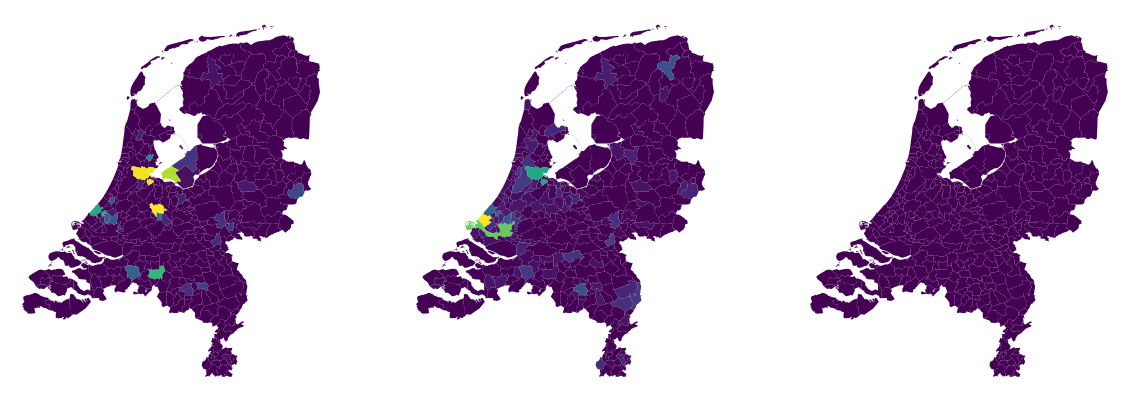

In [29]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,sharex=False,sharey=False, figsize=(20,8))
(ax1,ax2,ax3)[0].axis('off')
(ax1,ax2,ax3)[1].axis('off')
(ax1,ax2,ax3)[2].axis('off')

merged_df.plot("Gas Boiler - 2020", figsize=[12,100], ax = ax1)
merged_df.plot("Gas Boiler - 2030", figsize=[12,100], ax = ax2)
merged_df.plot("Gas Boiler - 2040", figsize=[12,100], ax = ax3)

plt.savefig(r'gasBoiler_results.png')
plt.show()

### Heat Pump Distribution

100%|██████████| 355/355 [00:00<00:00, 446.85it/s]


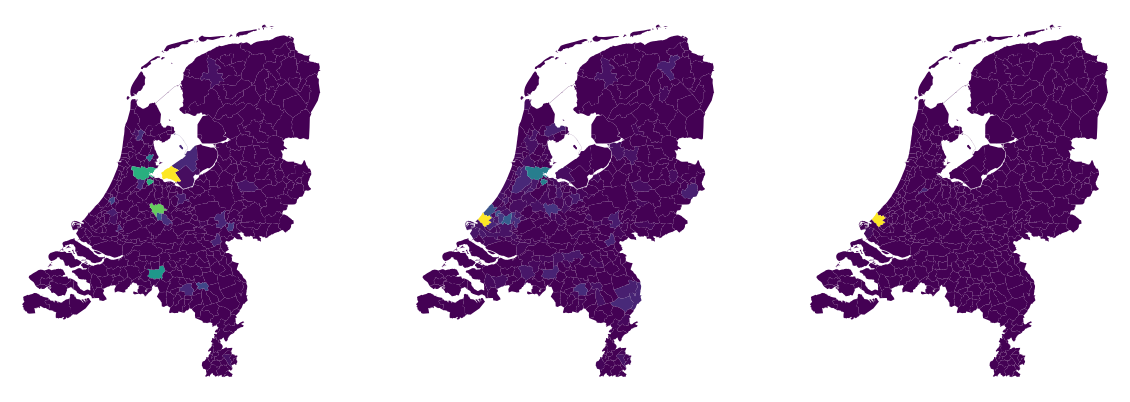

In [30]:
for i in tqdm(range(len(merged_df))):
    muniName = merged_df.loc[i, "gemeentenaam"]
    
    if muniName in list(facility_locations_df2020["gemeentenaam"]):
        
        valueFacility = facility_locations_df2020.loc[facility_locations_df2020["gemeentenaam"]==muniName]["Heat Pump"].values[0]
        merged_df.loc[i, "Heat Pump - 2020"] = valueFacility
        
        valueFacility = facility_locations_df2030.loc[facility_locations_df2030["gemeentenaam"]==muniName]["Heat Pump"].values[0]
        merged_df.loc[i, "Heat Pump - 2030"] = valueFacility
        
        valueFacility = facility_locations_df2040.loc[facility_locations_df2040["gemeentenaam"]==muniName]["Heat Pump"].values[0]
        merged_df.loc[i, "Heat Pump - 2040"] = valueFacility
        
    else:
        merged_df.loc[i, "Heat Pump - 2020"] = 0
        merged_df.loc[i, "Heat Pump - 2030"] = 0
        merged_df.loc[i, "Heat Pump - 2040"] = 0
        
        
        
fig,(ax1,ax2,ax3) = plt.subplots(1,3,sharex=False,sharey=False, figsize=(20,8))
(ax1,ax2,ax3)[0].axis('off')
(ax1,ax2,ax3)[1].axis('off')
(ax1,ax2,ax3)[2].axis('off')

merged_df.plot("Heat Pump - 2020", figsize=[12,100], ax = ax1)
merged_df.plot("Heat Pump - 2030", figsize=[12,100], ax = ax2)
merged_df.plot("Heat Pump - 2040", figsize=[12,100], ax = ax3)

plt.savefig(r'heatPump_results.png')
plt.show()

### Biomass CHP Distribution

100%|██████████| 355/355 [00:00<00:00, 442.44it/s]


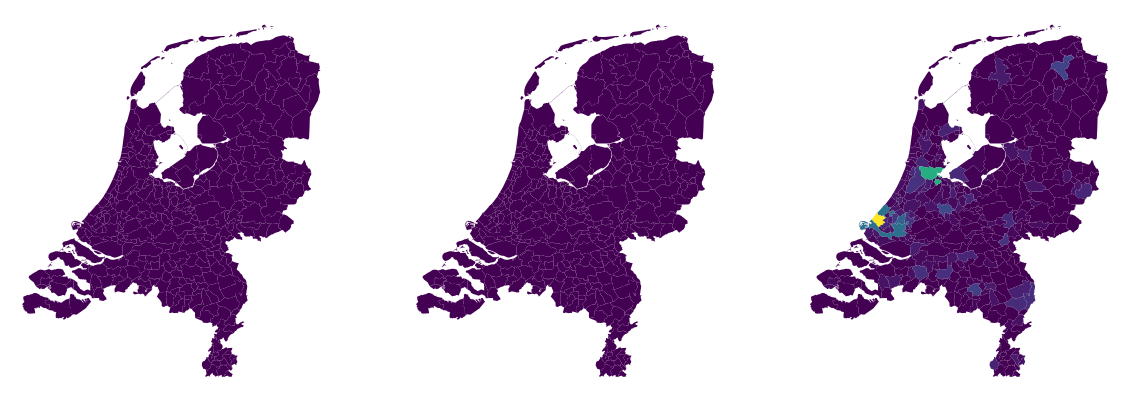

In [31]:
for i in tqdm(range(len(merged_df))):
    muniName = merged_df.loc[i, "gemeentenaam"]
    
    if muniName in list(facility_locations_df2020["gemeentenaam"]):
        
        valueFacility = facility_locations_df2020.loc[facility_locations_df2020["gemeentenaam"]==muniName]["Biomass CHP"].values[0]
        merged_df.loc[i, "Biomass CHP - 2020"] = valueFacility
        
        valueFacility = facility_locations_df2030.loc[facility_locations_df2030["gemeentenaam"]==muniName]["Biomass CHP"].values[0]
        merged_df.loc[i, "Biomass CHP - 2030"] = valueFacility
        
        valueFacility = facility_locations_df2040.loc[facility_locations_df2040["gemeentenaam"]==muniName]["Biomass CHP"].values[0]
        merged_df.loc[i, "Biomass CHP - 2040"] = valueFacility
        
    else:
        merged_df.loc[i, "Biomass CHP - 2020"] = 0
        merged_df.loc[i, "Biomass CHP - 2030"] = 0
        merged_df.loc[i, "Biomass CHP - 2040"] = 0
        
fig,(ax1,ax2,ax3) = plt.subplots(1,3,sharex=False,sharey=False, figsize=(20,8))
(ax1,ax2,ax3)[0].axis('off')
(ax1,ax2,ax3)[1].axis('off')
(ax1,ax2,ax3)[2].axis('off')

merged_df.plot("Biomass CHP - 2020", figsize=[12,100], ax = ax1)
merged_df.plot("Biomass CHP - 2030", figsize=[12,100], ax = ax2)
merged_df.plot("Biomass CHP - 2040", figsize=[12,100], ax = ax3)

plt.savefig(r'biomassCHP_results.png')
plt.show()

### Pipeline Network

In [32]:
centroids = merged_df.copy()
centroids.geometry = centroids['geometry'].centroid
centroids.loc[102,"geometry"] = Point(82000,432000)

centroids.crs = merged_df.crs

In [33]:
pipelineNetwork = pd.read_csv(r"model_data/result_pipeline_df.csv")
pipelineNetwork = pipelineNetwork.drop(["Unnamed: 0", "add_pipeline_cap"], axis=1)

pipelineNetwork2020 = pipelineNetwork.loc[pipelineNetwork["decade"] == 0]
pipelineNetwork2020 = pipelineNetwork2020.reset_index(drop=True)

pipelineNetwork2030 = pipelineNetwork.loc[pipelineNetwork["decade"] == 1]
pipelineNetwork2030 = pipelineNetwork2030.reset_index(drop=True)

pipelineNetwork2040 = pipelineNetwork.loc[pipelineNetwork["decade"] == 2]
pipelineNetwork2040 = pipelineNetwork2040.reset_index(drop=True)

In [34]:
pipelineNetwork2020["geometry"] = None
pipelineNetwork2030["geometry"] = None
pipelineNetwork2040["geometry"] = None

for i in range(len(pipelineNetwork2020)):
    muni1 = pipelineNetwork2020.iloc[i,0]
    muni2 = pipelineNetwork2020.iloc[i,1]
    pipeCap = pipelineNetwork2020.iloc[i,3]
    
    if pipeCap > 0.1:
        point1 = centroids.loc[centroids["gemeentenaam"]==muni1]["geometry"]
        point2 = centroids.loc[centroids["gemeentenaam"]==muni2]["geometry"]
        
        pipelineNetwork2020.loc[i, "geometry"] = LineString([(point1.x,point1.y), (point2.x,point2.y)])

pipelineNetwork2020 = gpd.GeoDataFrame(pipelineNetwork2020, crs=merged_df.crs, geometry=pipelineNetwork2020['geometry'])

for i in range(len(pipelineNetwork2030)):
    muni1 = pipelineNetwork2030.iloc[i,0]
    muni2 = pipelineNetwork2030.iloc[i,1]
    pipeCap = pipelineNetwork2030.iloc[i,3]
    
    if pipeCap > 0.1:
        point1 = centroids.loc[centroids["gemeentenaam"]==muni1]["geometry"]
        point2 = centroids.loc[centroids["gemeentenaam"]==muni2]["geometry"]
        
        pipelineNetwork2030.loc[i, "geometry"] = LineString([(point1.x,point1.y), (point2.x,point2.y)])

pipelineNetwork2030 = gpd.GeoDataFrame(pipelineNetwork2030, crs=merged_df.crs, geometry=pipelineNetwork2030['geometry'])


for i in range(len(pipelineNetwork2040)):
    muni1 = pipelineNetwork2040.iloc[i,0]
    muni2 = pipelineNetwork2040.iloc[i,1]
    pipeCap = pipelineNetwork2040.iloc[i,3]
    
    if pipeCap > 0.1:
        point1 = centroids.loc[centroids["gemeentenaam"]==muni1]["geometry"]
        point2 = centroids.loc[centroids["gemeentenaam"]==muni2]["geometry"]
        
        pipelineNetwork2040.loc[i, "geometry"] = LineString([(point1.x,point1.y), (point2.x,point2.y)])

pipelineNetwork2040 = gpd.GeoDataFrame(pipelineNetwork2040, crs=merged_df.crs, geometry=pipelineNetwork2040['geometry'])

In [35]:
for i in range(len(pipelineNetwork2020)):
    max2040 = math.sqrt(max(pipelineNetwork2040["current_pipeline_cap"]))
    
    if pipelineNetwork2020.loc[i,"current_pipeline_cap"] < 0.001:
        pipelineNetwork2020.loc[i,"lineWidth"] = 0
    else:
        pipelineNetwork2020.loc[i,"lineWidth"] = (math.sqrt(pipelineNetwork2020.loc[i,"current_pipeline_cap"]) / max2040)*10
    
    if pipelineNetwork2030.loc[i,"current_pipeline_cap"] < 0.001:
        pipelineNetwork2030.loc[i,"lineWidth"] = 0
    else:
        pipelineNetwork2030.loc[i,"lineWidth"] = (math.sqrt(pipelineNetwork2030.loc[i,"current_pipeline_cap"]) / max2040)*10
    
    if pipelineNetwork2040.loc[i,"current_pipeline_cap"] < 0.001:
        pipelineNetwork2040.loc[i,"lineWidth"] = 0
    else:
        pipelineNetwork2040.loc[i,"lineWidth"] = (math.sqrt(pipelineNetwork2040.loc[i,"current_pipeline_cap"]) / max2040)*10

100%|██████████| 600/600 [04:15<00:00,  2.28it/s]


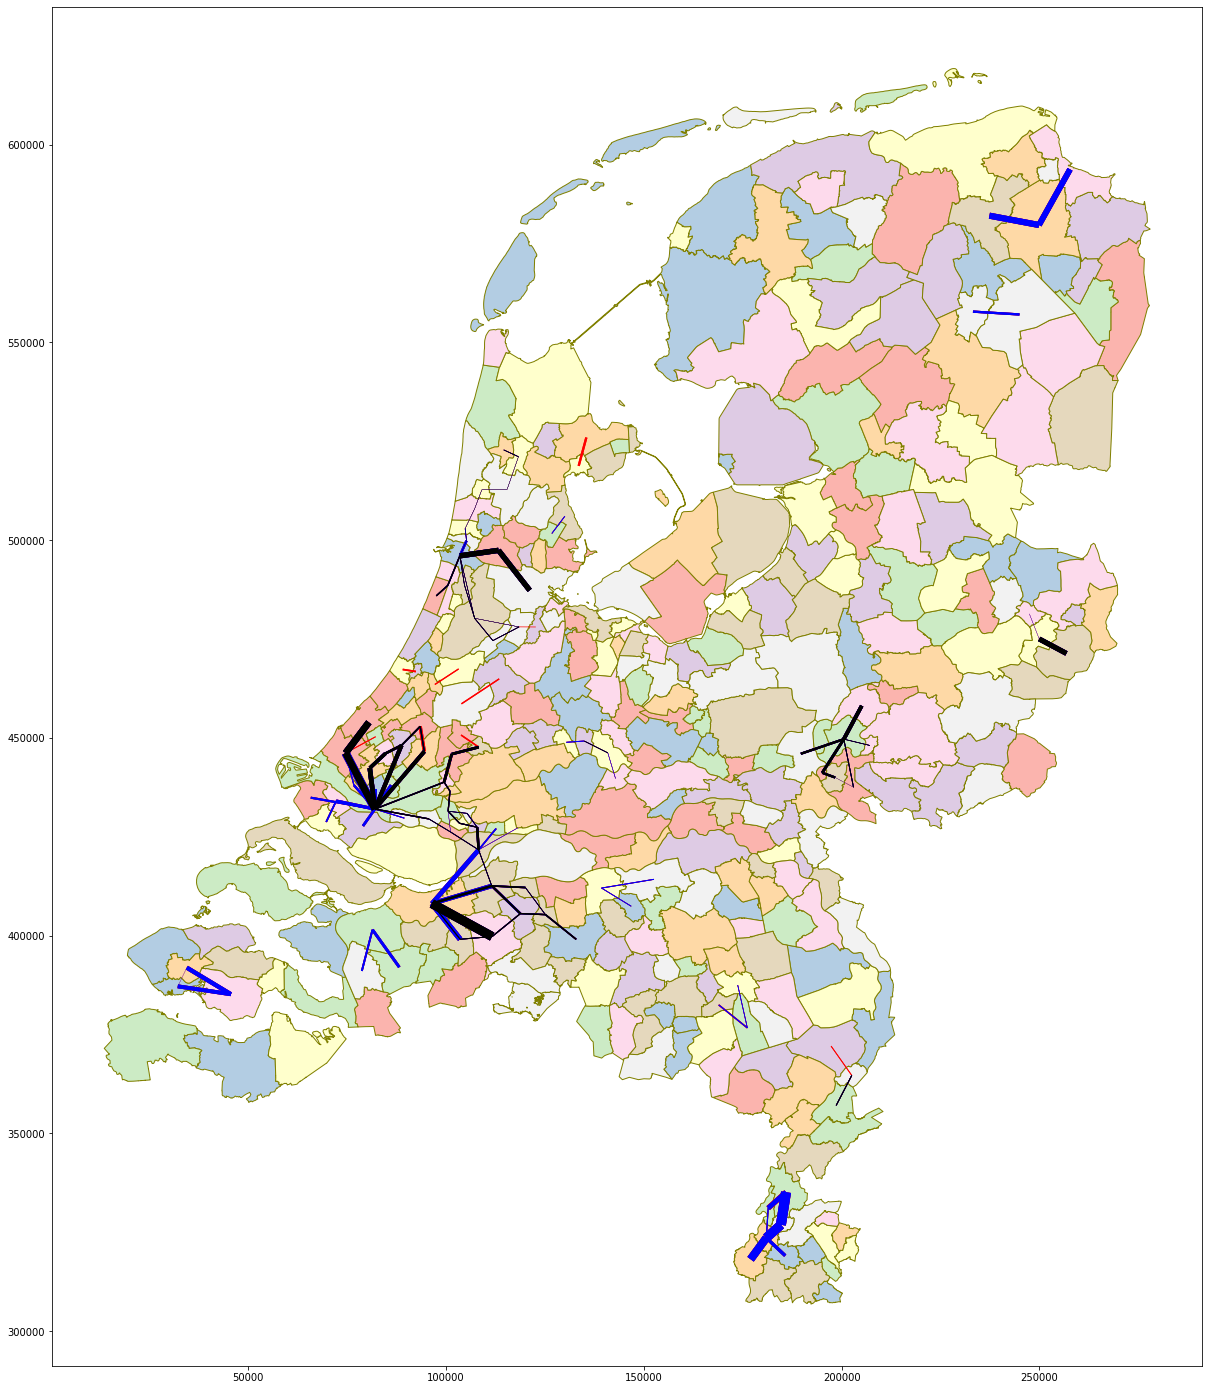

In [37]:
fig, ax = plt.subplots(figsize=(25, 25))
#ax.axis('off')
merged_df.plot(cmap="Pastel1", ax=ax, edgecolor="olive")
for i in tqdm(range(len(pipelineNetwork2040))):
    pipelineNetwork2040.geometry.iloc[i:i+1].plot(ax=ax, color='Red', linewidth=pipelineNetwork2040.loc[i,"lineWidth"])

for i in tqdm(range(len(pipelineNetwork2030))):
    pipelineNetwork2030.geometry.iloc[i:i+1].plot(ax=ax, color='Blue', linewidth=pipelineNetwork2030.loc[i,"lineWidth"])

for i in tqdm(range(len(pipelineNetwork2020))):
    pipelineNetwork2020.geometry.iloc[i:i+1].plot(ax=ax, color='Black', linewidth=pipelineNetwork2020.loc[i,"lineWidth"])

fig = ax.get_figure()
fig.savefig(r'pipelineMap.png')
plt.show()